# Проект HR-аналитика

## Описание задачи 

Предоставлены данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. 

Необходимо построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика

Импорт библиотек

In [1]:
!pip install phik -q 
!pip install optuna

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import phik
import math

In [3]:
from phik.report import plot_correlation_matrix
from phik import phik_matrix
from sklearn.svm import SVR

from math import fabs
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    OneHotEncoder, 
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler, 
    RobustScaler, 
    LabelEncoder
    )
from sklearn.impute import SimpleImputer
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression

Задаю константы

In [4]:
RANDOM_STATE = 48
TEST_SIZE = 0.25

# Задача №1

## Загрузка данных

In [5]:
try:
    train_df = pd.read_csv('datasets/train_job_satisfaction_rate.csv')
    test_features = pd.read_csv('datasets/test_features.csv')
    target_feature = pd.read_csv('datasets/test_target_job_satisfaction_rate.csv')
except:
    train_df = pd.read_csv('https://code.s3.yandex.net/datasets/train_job_satisfaction_rate.csv')
    test_features = pd.read_csv('https://code.s3.yandex.net/datasets/test_features.csv')
    target_feature = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_job_satisfaction_rate.csv')

## Предобработка данных

In [6]:
def watch_df(df): #функция для просмотра информации по датафрейму
    df.info()
    display(df.head(10))

In [7]:
list_of_dfs = [train_df,test_features,target_feature]

In [8]:
for df in list_of_dfs:
    watch_df(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


id        dept   level workload  employment_years last_year_promo  \
0  155278       sales  junior   medium                 2              no   
1  653870          hr  junior     high                 2              no   
2  184592       sales  junior      low                 1              no   
3  171431  technology  junior      low                 4              no   
4  693419          hr  junior   medium                 1              no   
5  405448          hr  middle      low                 7              no   
6  857135       sales  sinior   medium                 9              no   
7  400657  purchasing  middle     high                 9              no   
8  198846          hr  junior      low                 1              no   
9  149797  technology  middle     high                 6              no   

  last_year_violations  supervisor_evaluation  salary  job_satisfaction_rate  
0                   no                      1   24000                   0.58  
1                   no                      5   38400                   0.76  
2                   no                      2   12000                   0.11  
3                   no                      2   18000                   0.37  
4                   no                      3   22800                   0.20  
5                   no                      4   30000                   0.78  
6                   no                      3   56400                   0.56  
7                   no                      3   52800                   0.44  
8                   no                      2   13200                   0.14  
9                   no                      3   54000                   0.47

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


id        dept   level workload  employment_years last_year_promo  \
0  485046   marketing  junior   medium                 2              no   
1  686555          hr  junior   medium                 1              no   
2  467458       sales  middle      low                 5              no   
3  418655       sales  middle      low                 6              no   
4  789145          hr  middle   medium                 5              no   
5  429973  purchasing  middle   medium                 6              no   
6  850699  technology  junior   medium                 3              no   
7  500791       sales  middle     high                 9              no   
8  767867   marketing  middle     high                 3              no   
9  937235       sales  junior   medium                 1              no   

  last_year_violations  supervisor_evaluation  salary  
0                   no                      5   28800  
1                   no                      4   30000  
2                   no                      4   19200  
3                   no                      4   19200  
4                   no                      5   40800  
5                   no                      3   42000  
6                   no                      3   26400  
7                   no                      4   49200  
8                  yes                      4   62400  
9                  yes                      3   26400

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


id  job_satisfaction_rate
0  130604                   0.74
1  825977                   0.75
2  418490                   0.60
3  555320                   0.72
4  826430                   0.08
5  817219                   0.76
6  269033                   0.64
7  962356                   0.38
8  649052                   0.14
9  532834                   0.59

Итог: 

Данные имеют подходящие форматы.

Наличие пропусков:

 - в датафрейме train_df в столбцах dept и level 
 - в test_features в столбцах dept и level
 
Надо проверить явные и неявные дубликаты.

In [9]:
#проверка строк с пропущенными значениями
display(train_df[train_df['dept'].isnull()])
display(train_df[train_df['level'].isnull()])

id dept   level workload  employment_years last_year_promo  \
1526  694746  NaN  junior   medium                 5              no   
1630  814624  NaN  junior   medium                 3              no   
1633  475114  NaN  junior     high                 4              no   
2781  497243  NaN  junior   medium                 1              no   
2975  168668  NaN  junior      low                 3              no   
3866  641150  NaN  junior      low                 3              no   

     last_year_violations  supervisor_evaluation  salary  \
1526                   no                      4   21600   
1630                   no                      4   24000   
1633                   no                      4   31200   
2781                   no                      3   26400   
2975                   no                      4   18000   
3866                  yes                      4   12000   

      job_satisfaction_rate  
1526                   0.62  
1630                   0.88  
1633                   0.63  
2781                   0.28  
2975                   0.88  
3866                   0.54

id   dept level workload  employment_years last_year_promo  \
1209  631073  sales   NaN   medium                 1              no   
1469  416327  sales   NaN      low                 1              no   
1745  135043  sales   NaN   medium                 1              no   
2522  998838  sales   NaN   medium                 1              no   

     last_year_violations  supervisor_evaluation  salary  \
1209                   no                      4   27600   
1469                   no                      5   18000   
1745                   no                      3   26400   
2522                   no                      5   27600   

      job_satisfaction_rate  
1209                   0.66  
1469                   0.73  
1745                   0.30  
2522                   0.71

In [10]:
#проверка строк с пропущенными значениями
display(test_features[test_features['dept'].isnull()])
display(test_features[test_features['level'].isnull()])

id dept   level workload  employment_years last_year_promo  \
191   609865  NaN  junior   medium                 1              no   
1196  832342  NaN  junior   medium                 1              no   

     last_year_violations  supervisor_evaluation  salary  
191                    no                      1   20400  
1196                   no                      4   28800

id   dept level workload  employment_years last_year_promo  \
312  471990  sales   NaN      low                 1              no   

    last_year_violations  supervisor_evaluation  salary  
312                   no                      3   12000

В обоих случаях пропуски в данных касаются личных данных конкретного пользователя. В таком случае заполнение данных средним, медианным или модальным значением будет некорректным. Такие строки необходимо удалить.

In [11]:
def unique_values_in_columns(df):
    display(df.head(5))
    for i in df.columns:
        print(df[i].value_counts(), '/n')

In [12]:
for df in list_of_dfs:
    unique_values_in_columns(df)

id        dept   level workload  employment_years last_year_promo  \
0  155278       sales  junior   medium                 2              no   
1  653870          hr  junior     high                 2              no   
2  184592       sales  junior      low                 1              no   
3  171431  technology  junior      low                 4              no   
4  693419          hr  junior   medium                 1              no   

  last_year_violations  supervisor_evaluation  salary  job_satisfaction_rate  
0                   no                      1   24000                   0.58  
1                   no                      5   38400                   0.76  
2                   no                      2   12000                   0.11  
3                   no                      2   18000                   0.37  
4                   no                      3   22800                   0.20

296961    1
898488    1
783768    1
910746    1
613789    1
         ..
463527    1
862888    1
548638    1
624165    1
428031    1
Name: id, Length: 4000, dtype: int64 /n
sales         1512
technology     866
purchasing     610
marketing      550
hr             456
Name: dept, dtype: int64 /n
junior    1894
middle    1744
sinior     358
Name: level, dtype: int64 /n
medium    2066
low       1200
high       734
Name: workload, dtype: int64 /n
1     966
2     785
3     483
4     384
5     380
7     301
6     287
8     193
9     130
10     91
Name: employment_years, dtype: int64 /n
no     3880
yes     120
Name: last_year_promo, dtype: int64 /n
no     3441
yes     559
Name: last_year_violations, dtype: int64 /n
4    1603
3    1263
5     546
2     387
1     201
Name: supervisor_evaluation, dtype: int64 /n
24000    187
27600    184
26400    167
21600    167
28800    164
        ... 
85200      1
91200      1
97200      1
74400      1
98400      1
Name: salary, Length: 68, dtype: int64 /n
0.6

id       dept   level workload  employment_years last_year_promo  \
0  485046  marketing  junior   medium                 2              no   
1  686555         hr  junior   medium                 1              no   
2  467458      sales  middle      low                 5              no   
3  418655      sales  middle      low                 6              no   
4  789145         hr  middle   medium                 5              no   

  last_year_violations  supervisor_evaluation  salary  
0                   no                      5   28800  
1                   no                      4   30000  
2                   no                      4   19200  
3                   no                      4   19200  
4                   no                      5   40800

727043    1
340625    1
996005    1
356579    1
791203    1
         ..
683546    1
867647    1
314685    1
527675    1
200700    1
Name: id, Length: 2000, dtype: int64 /n
sales         763
technology    455
marketing     279
purchasing    273
hr            227
                1
Name: dept, dtype: int64 /n
junior    974
middle    854
sinior    171
Name: level, dtype: int64 /n
medium    1043
low        593
high       363
             1
Name: workload, dtype: int64 /n
1     522
2     374
3     234
4     187
5     179
7     174
6     138
8      91
9      66
10     35
Name: employment_years, dtype: int64 /n
no     1937
yes      63
Name: last_year_promo, dtype: int64 /n
no     1738
yes     262
Name: last_year_violations, dtype: int64 /n
4    857
3    575
5    284
2    196
1     88
Name: supervisor_evaluation, dtype: int64 /n
27600    109
26400     95
24000     93
19200     83
21600     83
        ... 
88800      2
80400      2
96000      1
75600      1
92400      1
Name: salary, Length: 66,

id  job_satisfaction_rate
0  130604                   0.74
1  825977                   0.75
2  418490                   0.60
3  555320                   0.72
4  826430                   0.08

727043    1
791203    1
836287    1
281278    1
404154    1
         ..
875851    1
230381    1
757063    1
628038    1
200700    1
Name: id, Length: 2000, dtype: int64 /n
0.70    49
0.67    48
0.65    47
0.75    47
0.68    47
        ..
0.05     2
0.99     2
0.03     1
0.96     1
0.04     1
Name: job_satisfaction_rate, Length: 98, dtype: int64 /n


Есть категории-пропуски в столбцах debt и workload. Выведу пропуски

In [13]:
display(test_features[test_features['dept'] == ' '])
display(test_features[test_features['workload'] == ' '])

id dept   level workload  employment_years last_year_promo  \
1699  822186       middle   medium                 3              no   

     last_year_violations  supervisor_evaluation  salary  
1699                   no                      4   38400

id       dept   level workload  employment_years last_year_promo  \
15  590867  marketing  junior                          4              no   

   last_year_violations  supervisor_evaluation  salary  
15                   no                      4   28800

Пропуски заполню в шаге pipeline с помощью наиболее часто встречающихся значений.

В датафреймах есть грамматическая ошибка: название класса senior написано как sinior. Исправлю эту ошибку на следующем шаге

In [14]:
for df in list_of_dfs:
    df.replace('sinior', 'senior', inplace = True)

### Вывод

Данные подходят для анализа, однако для работы с ними потребуется устранить некоторые недочеты. А именно: исправить грамматические ошибки и заполнить пропуски данных при работе с пайплайном

## Исследовательский анализ данных

### Исследование датафреймов

Датафрейм имеет 6 категориальных признаков и 3 количественных. 

In [15]:
sns.set(rc={'figure.figsize':(8,6)}) # задаю размеры будущих графиков

Написание функций для исследовательского анализа данных

In [16]:
# функция для построения графиков категориальных признаков
def cat_features_analys(df, feature):
    
    sns.countplot(
        data = df,
        x = feature,
        palette = 'pastel',  
        ).set_title(f'Количество сотрудников, разделенных по признаку {feature}')
    
    plt.show()
    
# функция для построения графиков количественных признаков
def num_features_analys(df, feature):
    
    sns.histplot(
        data = df[feature],
        palette = 'pastel'
        ).set_title(f'Количество сотрудников, разделенных по признаку {feature}')
    
    plt.show()
    
    sns.boxplot(
        data = df,
        palette = 'pastel',
        y = feature
        )
    
    plt.show()

In [17]:
category_features = [    #список категориальных признаков
    'dept',
    'level',
    'workload',
    'last_year_promo',
    'last_year_violations',
    'supervisor_evaluation'
    ]

num_features = [    #список количественных признаков
    'employment_years',
    'salary'
    ]

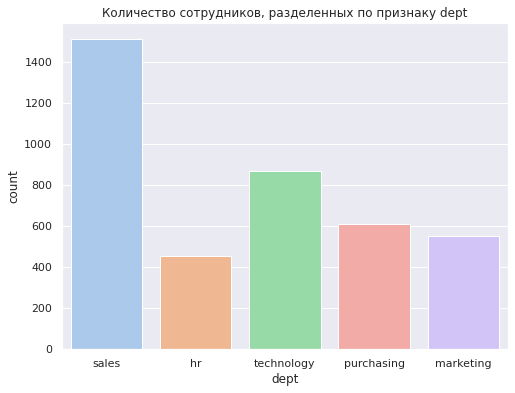

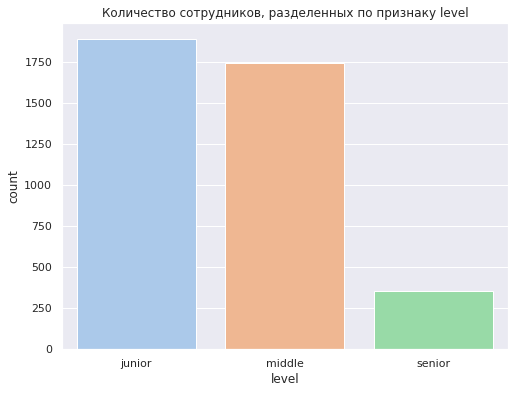

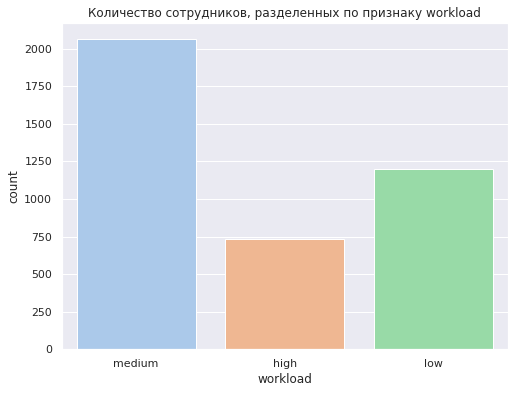

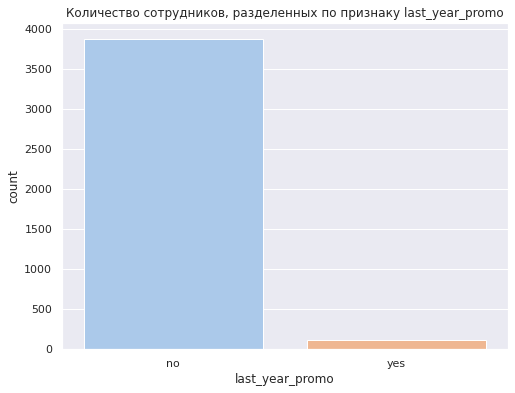

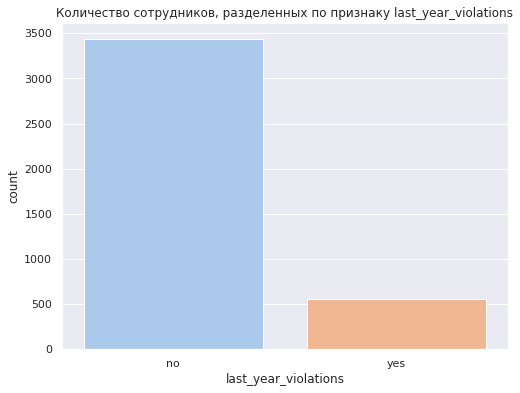

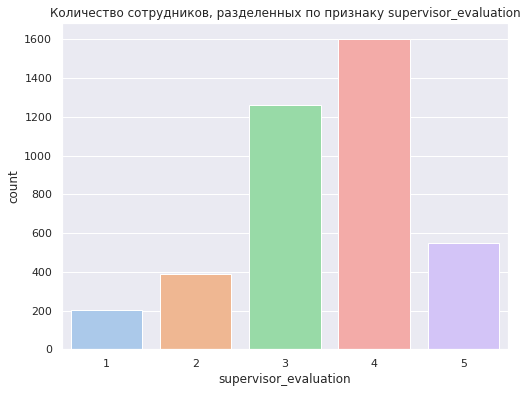

In [18]:
for cat_feature in category_features:
    cat_features_analys(train_df, cat_feature)

Выводы по категориальным признакам: 

- Данные в представленном датасете подходят для построения модели: распределение признаков выглядит органично. 


- Наибольшее число id представлено из отдела sales, наименьшее из hr. 


- Большая часть работников по признаку level относятся к классам junior и middle, класса senior очень мало.


- Загрузка распределена неравномерно: сотрудников с низкой загрузкой примерно половина от сотрудников средней загрузки. 


- Крайне мало сотрудников получают повышения (около 3%).


- Нарушений трудового договора много: около 12% сотрудников нарушали трудовой договор за последний год.


- Руководители чаще всего выбирают между оценкой сотрудника в 3 или 4 балла. Только около 14% сотрудников получают максимальную оценку. 


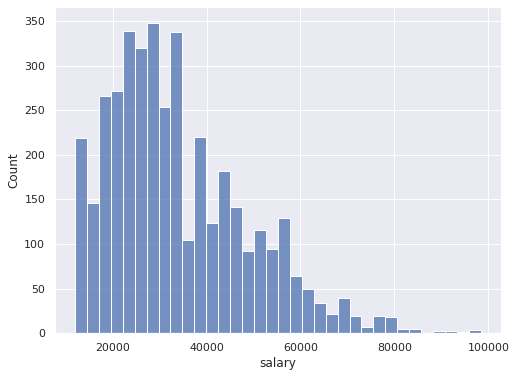

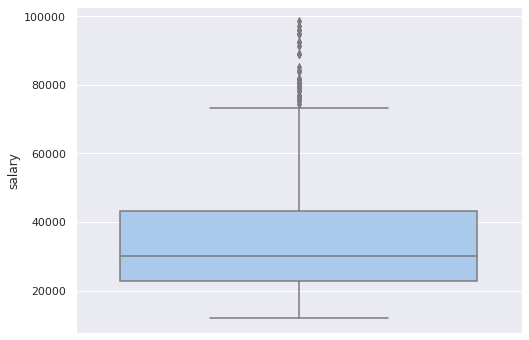

In [19]:
sns.histplot(
    data = train_df['salary'],
    palette = 'pastel'
    )
    
plt.show()
    
sns.boxplot(
    data = train_df,
    palette = 'pastel',
    y = 'salary'
    )
    
plt.show()

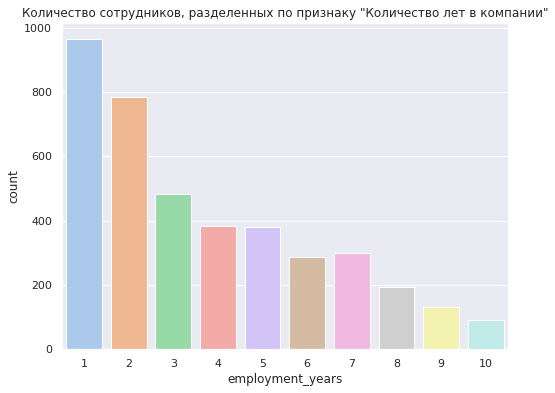

In [20]:
sns.countplot(
    data = train_df,
    x = 'employment_years',
    palette = 'pastel',  
    ).set_title('Количество сотрудников, разделенных по признаку "Количество лет в компании"')
    
plt.show()

Выводы по количественным признакам: 

- зависимость числа сотрудников от их опыта обратная - чем больше опыт, тем меньше сотрудников. это может говорить о текучке кадров в организации, и в целом негативно влияет на рабочие процессы: ядро персонала составляют неопытные сотрудники. 


- зарплаты распределены нормально. На графике видны выбросы: скорее всего, датасет неоднородный, в него включены как рядовые сотрудники, так и руководители. Это следует учесть при построении модели.

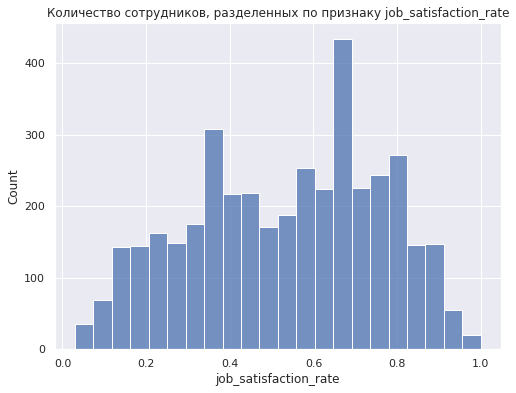

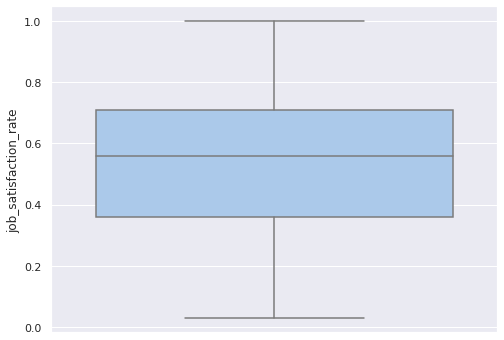

In [21]:
num_features_analys(train_df, 'job_satisfaction_rate') # исследование таргета

Гистограмма целевого признака имеет две ярко выраженные вершины: около 3,7 и 6,6. Возможно, по результатам анализа удастся выделить две явных категории сотрудников для анализа.

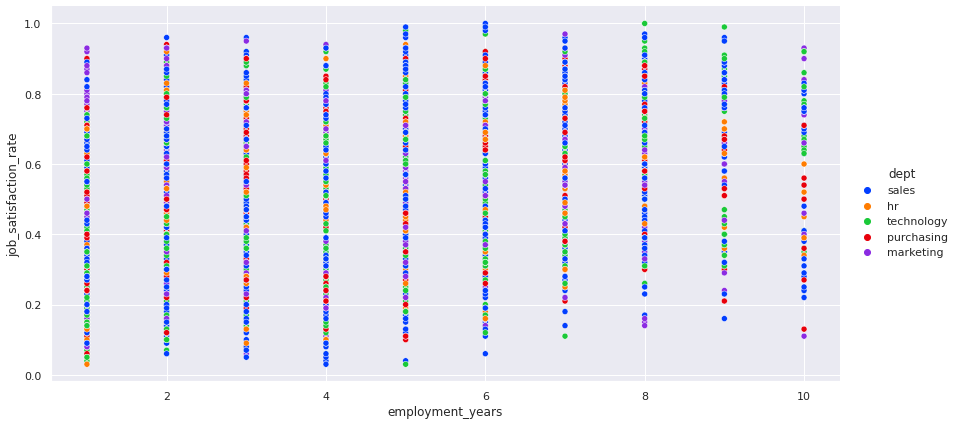

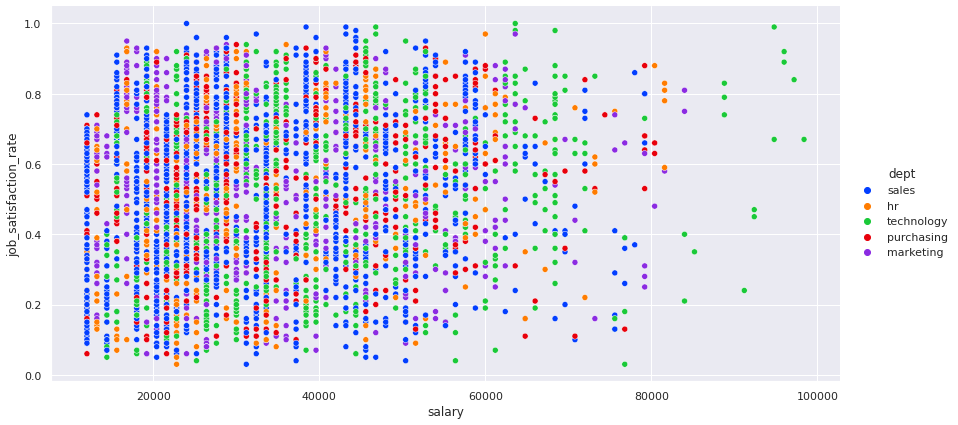

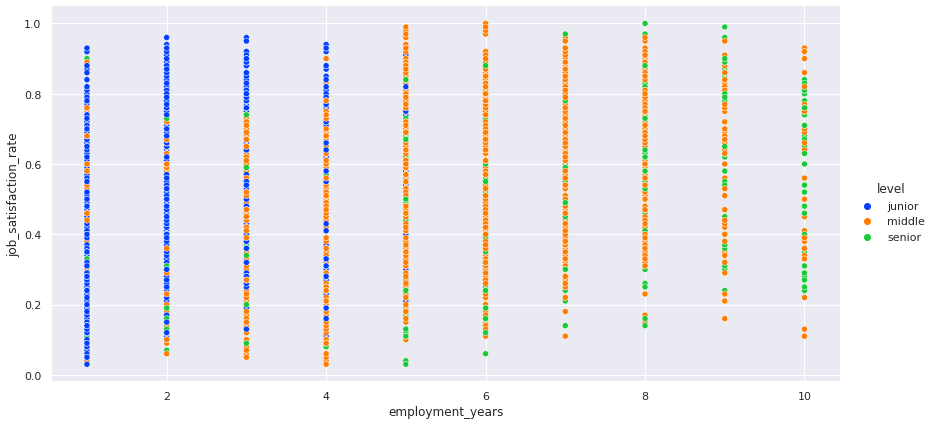

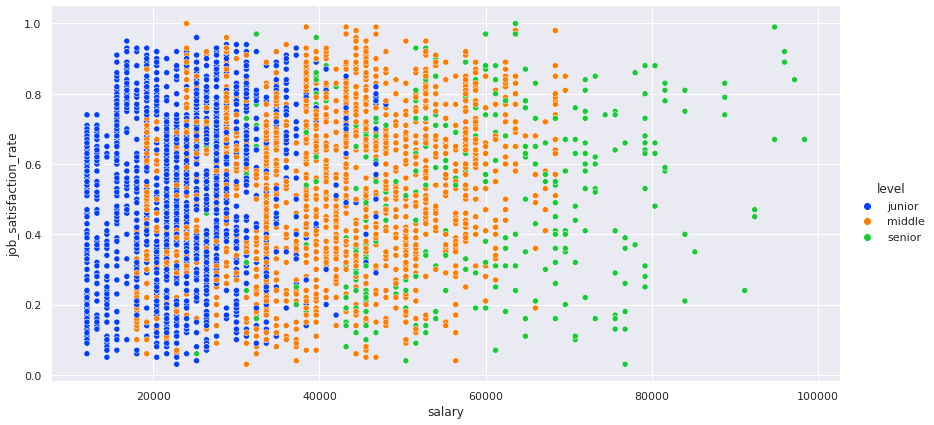

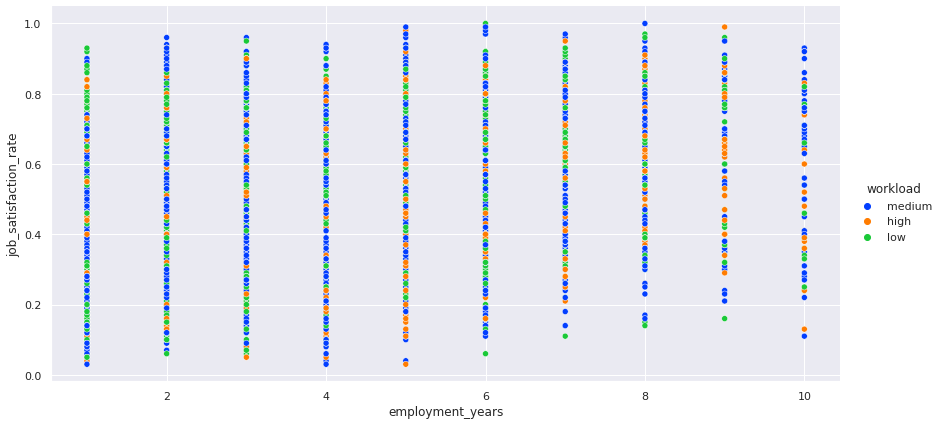

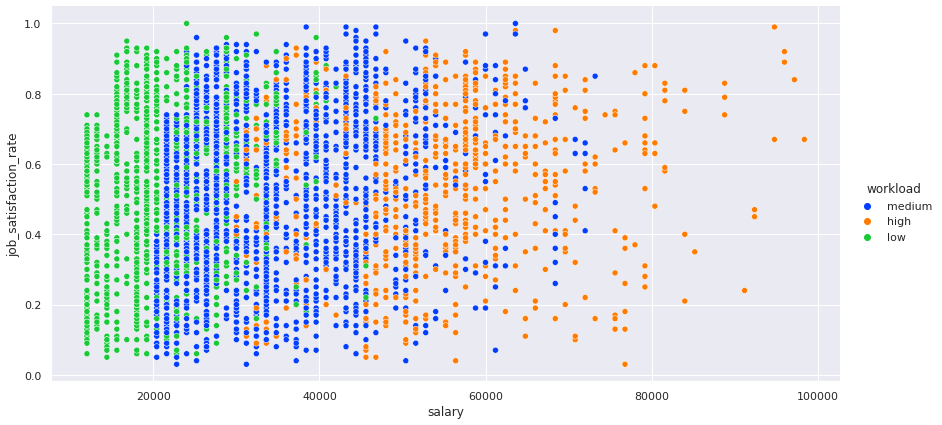

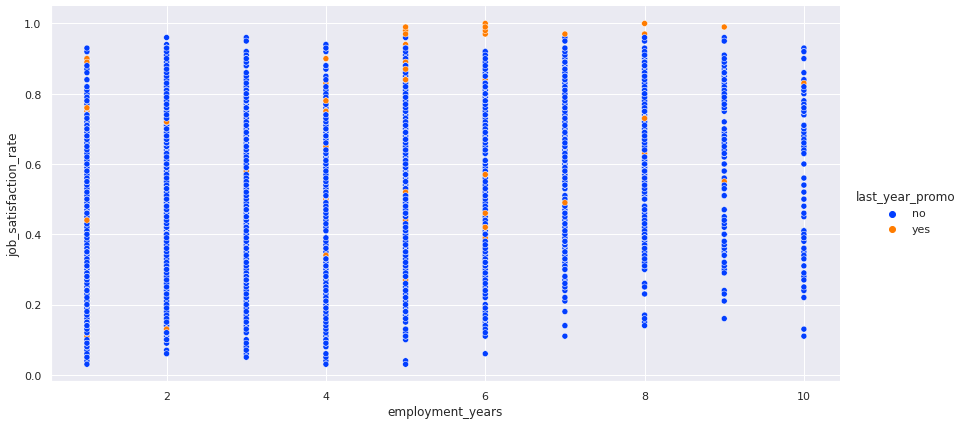

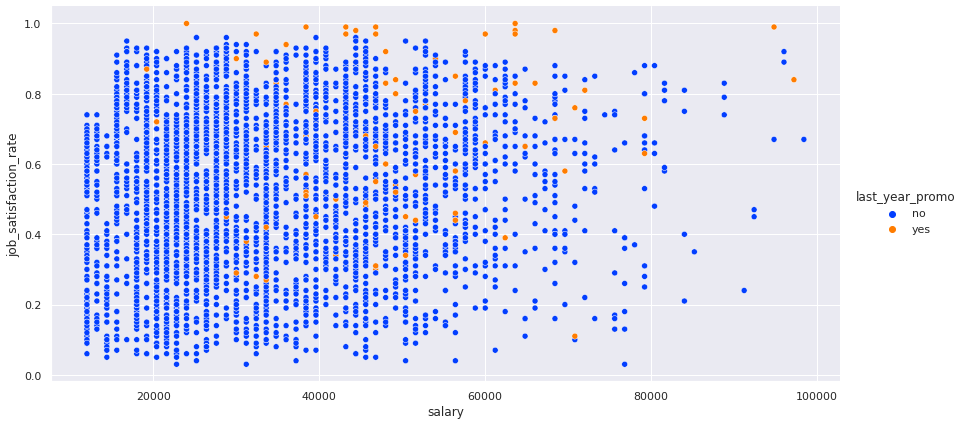

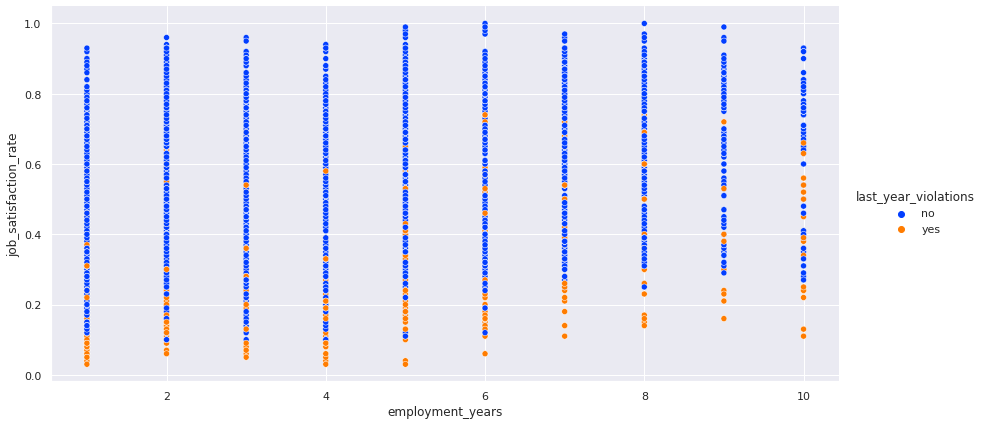

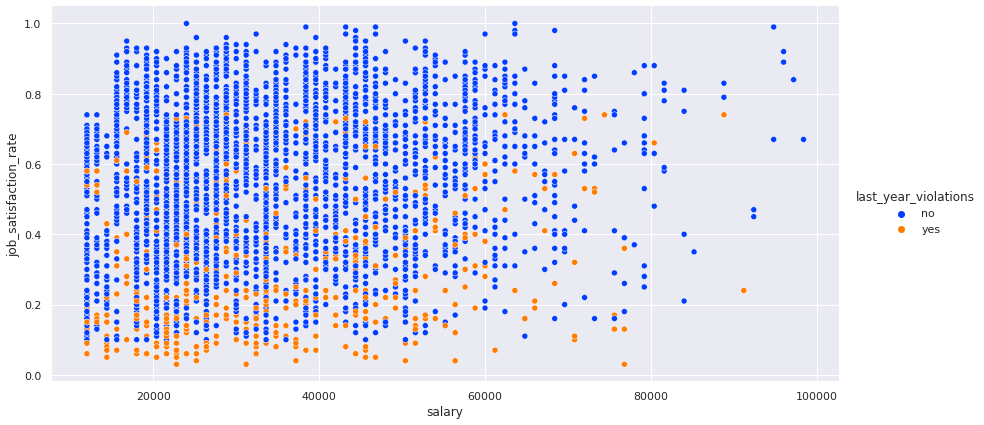

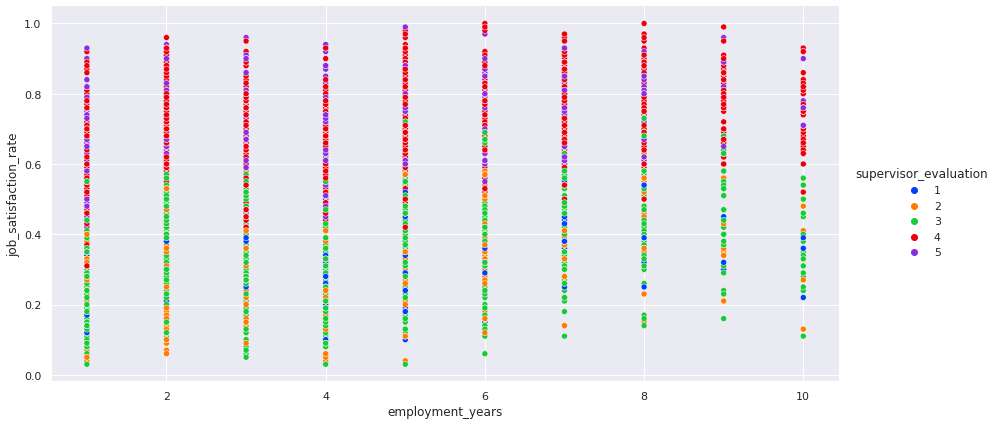

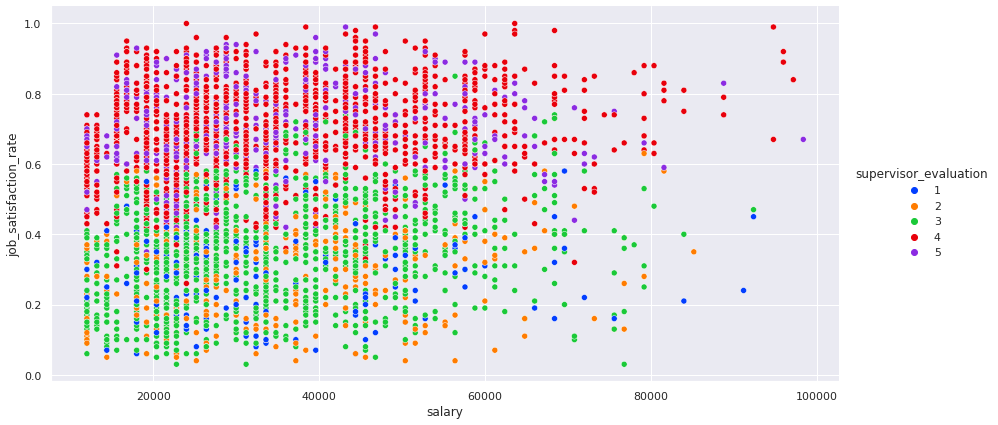

In [22]:
for category in category_features: #диаграммы рассеяния всех количественных признаков с учетом значения категориальных
    for num in num_features:
        sns.pairplot(
            data = train_df,
            kind='scatter',
            x_vars = num,
            y_vars = 'job_satisfaction_rate',
            height = 6,
            aspect = 2,
            hue = category,
            palette = 'bright'
            )
        
        plt.show()

Выводы по анализу зависимости признаков: 

- Нет сильной зависимости удовлетворенности работой от размера зарплаты. Есть несколько сотрудников it-отдела,       входящих в топ самых высокооплачиваемых, при этом имеющих удовлетворенность работой менее 0.5


- Заметно, что базовые зарплаты it самые высокие. Максимальные зарплаты sales самые низкие из всех отделов.


- Распределение сотрудников по уровню достаточно четкое. Есть несколько аномалий: junior’ы, работающие в компании 4-5 лет. Сотрудники с высоким уровнем и малым количеством лет в компании, скорее всего, наняты недавно, сразу на позиции middle и senior 


- По графику, рассматривающему зависимость удовлетворенности работой от повышения видно, что повышение является одним из важнейших факторов высокой удовлетворенности. 


- Нарушение трудового договора напротив, сильно снижает удовлетворенность работой. 


- Нарушение трудового договора наиболее характерно для сотрудников с низкими зарплатами


- Высокая удовлетворенность работой и высокая оценка начальником сотрудника имеют сильную связь. Не хватает контекста данных: оценка руководителя является открытой и доступна сотруднику или нет. Если она закрыта от сотрудника, налицо закономерность: сотрудники, ставящие высокие оценки удовлетворенности работой, работают лучше. Если оценки открыты, можно предположить, что похвала начальника положительно влияет на оценку компании сотрудником.


- На диаграммах рассеяния заметна крайне высокая корелляция целевого признака с наличием повышения (влияет положительно) и наличием нарушения трудового договора (влияет отрицательно). Скорее всего, она и оказывает влияние на то, что в распределении целевого признака есть два пика. 

### Исследование датафрейма test_features

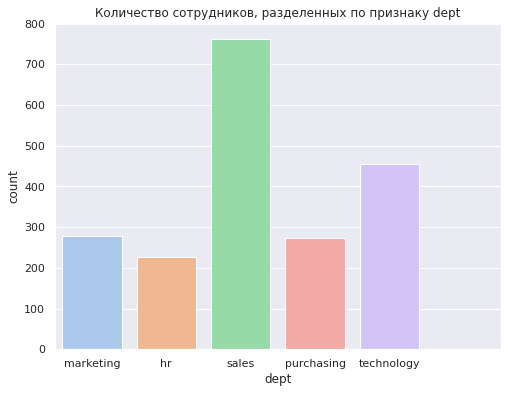

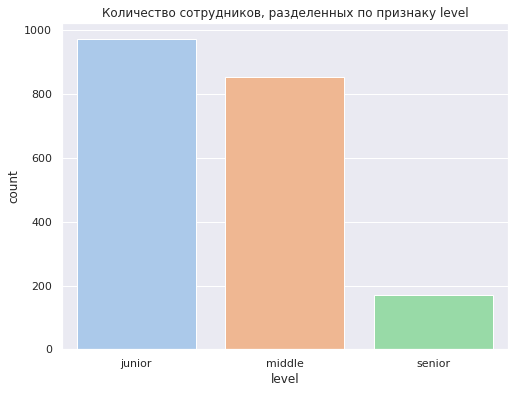

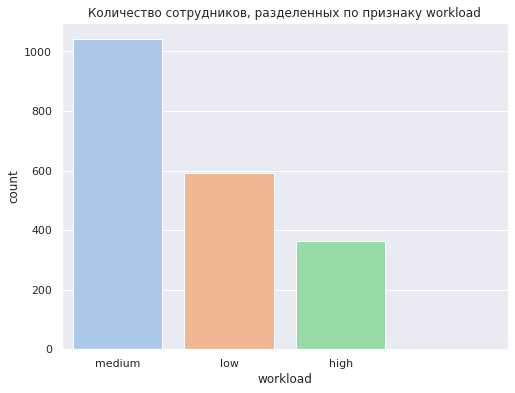

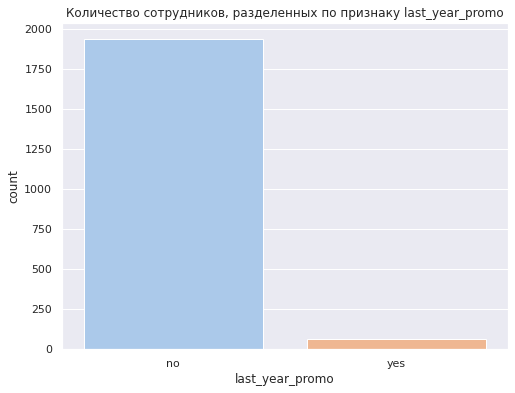

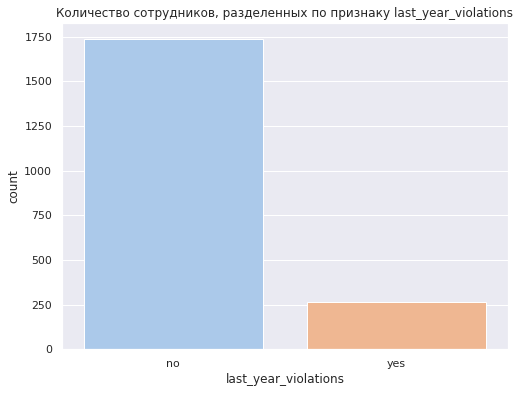

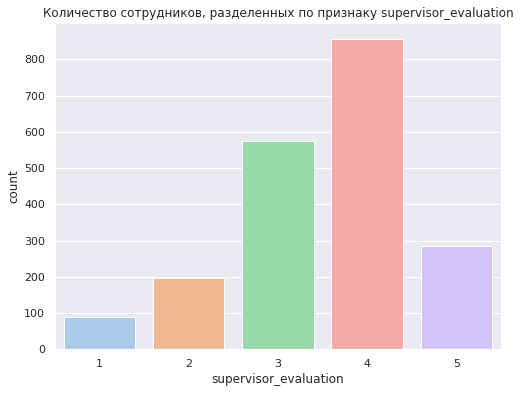

In [23]:
for cat_feature in category_features:
    cat_features_analys(test_features, cat_feature)

Распределения категориальных признаков соответствуют тренировочной выборке. 

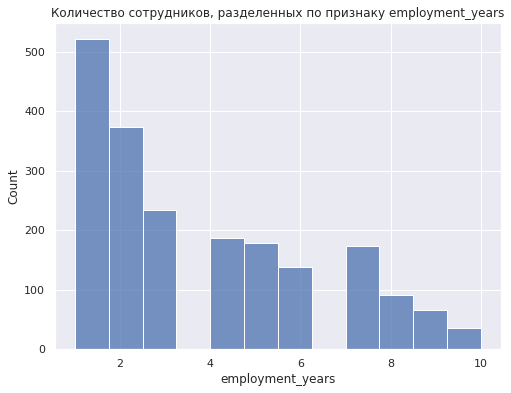

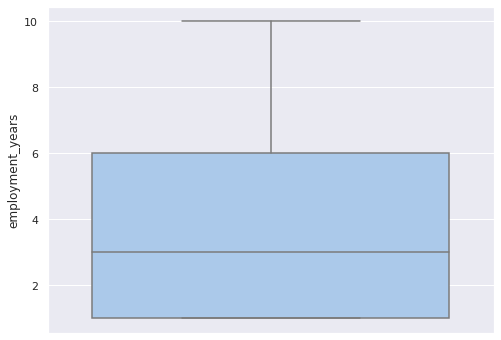

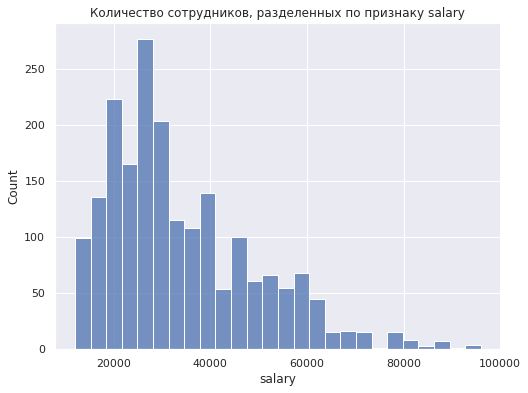

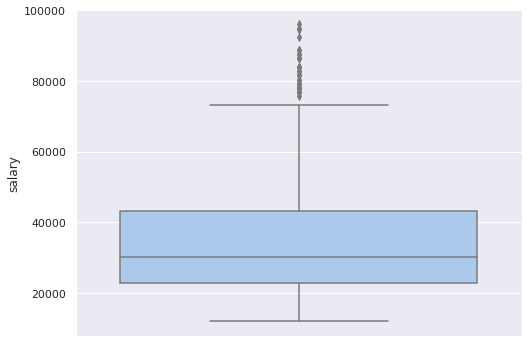

In [24]:
for num_feature in num_features:
    num_features_analys(test_features, num_feature)

В тестовой выборке больше id с меньшим опытом работы, о чем говорит положение графика boxplot. Распределение зарплаты соответствует тренировочной выборке

### Анализ датафрейма target_feature

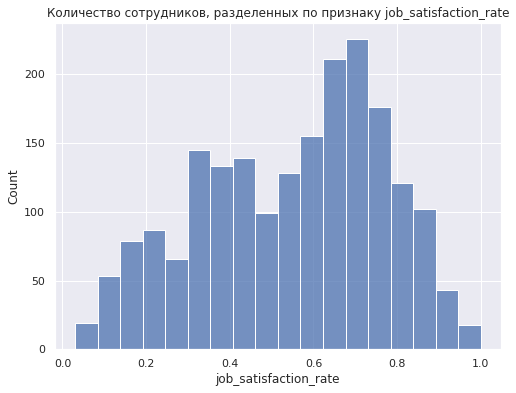

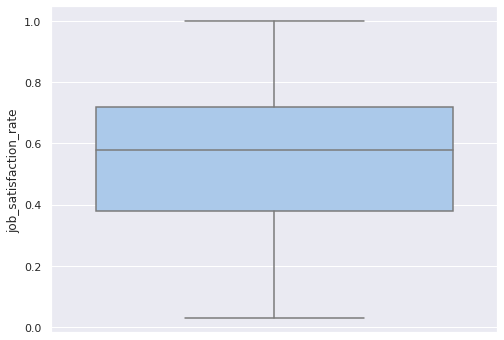

In [25]:
num_features_analys(target_feature, 'job_satisfaction_rate') # оценка таргета тестовой выборки

В данных целевого признака тестовой выборке также заметны две вершины на приблизительно тех же значениях, что и в тренировочной. Выборки равноценны и их можно использовать для моделирования. 

### Вывод

По итогам исследовательского анализа данных можно сделать первые выводы и дать рекомендации: 

- Заметна высокая корреляция между высокой удовлетворенностью и повышением. Возможно, в компании стоит разработать программу гарантированного карьерного роста: прописать сложную иерархию с конкретными ступенями для каждого отдела, а также расписать необходимые компетенции для повышения по службе.


- Крайне высокая корреляция между нарушением трудового договора и низкой удовлетворенностью. Так как число нарушений условий очень велико (около 12,5%) нужно проверить условия договоров. Есть вероятность, что жесткий трудовой договор является инструментом депремирования или аналогичного негативного воздействия на сотрудника. 


- Нужно больше данных по теме большого количества новичков (специалистов, которые 1-2 года в компании). Это является либо признаком большого расширения штата, связанного с освоением новых ниш и рынков, либо с текучкой кадров. в рамках этого пункта хотелось бы увидеть статистику по увольнениями персонала.


- Заметна высокая корреляция оценки сотрудника руководителем и удовлетворенность компанией. Однако, как один фактор влияет на другой: если оценка открытая, то она может мотивировать сотрудника к положительной оценке организации; если оценка закрытая то это показывает, что удовлетворенность - отражение производительности труда работника, которая отмечена руководителем. 

## Корреляционный анализ данных

### Тренировочная выборка

In [26]:
interval_features = [     # записываю интервальные признаки в переменную
    'job_satisfaction_rate',
    'salary'
    ]

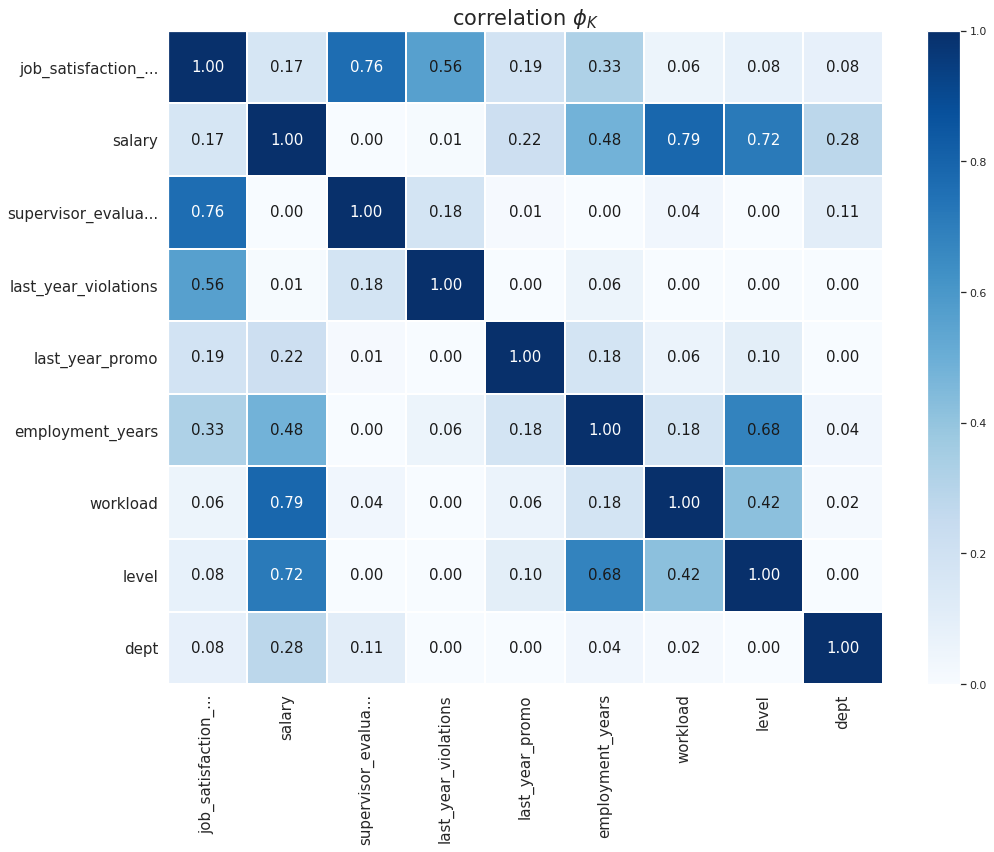

In [27]:
# корреляционный анализ датафрема train_df
phik_overview = train_df.drop(['id'], axis = 1).phik_matrix(interval_cols=interval_features)

plot_correlation_matrix(
    phik_overview.values, 
    x_labels=phik_overview.columns, 
    y_labels=phik_overview.index, 
    title=r"correlation $\phi_K$", 
    fontsize_factor=1.5,
    vmin=0, vmax=1,
    color_map='Blues',
    figsize=(15, 12)
    )

По оценке Phik matrix сильная корреляция целевого признака job_satisfaction_rate прослеживается с last_year_violations и supervisor_evaluation. 

Крайне высокая корреляция у пар признаков salary-workload и salary-level. 

### Тестовая выборка

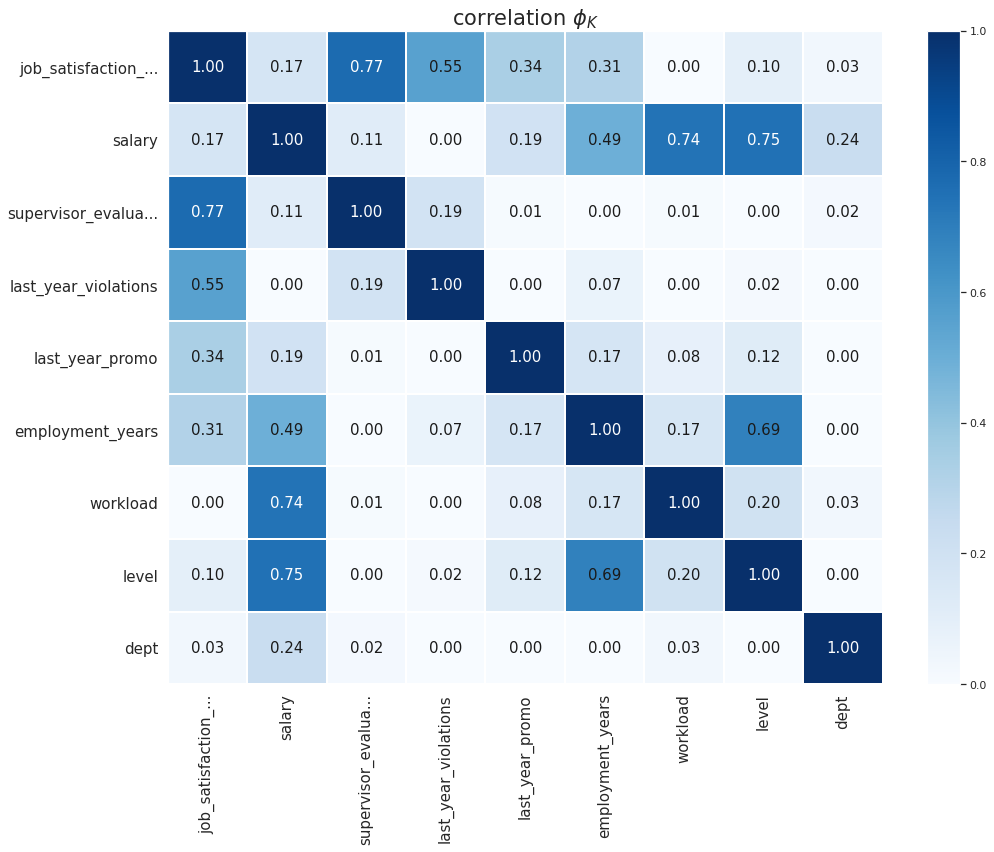

In [28]:
phik_overview_test = phik_matrix(test_features.merge(target_feature, how='left').drop(['id'], axis=1), interval_cols=interval_features)

plot_correlation_matrix(
    phik_overview_test.values, 
    x_labels=phik_overview_test.columns, 
    y_labels=phik_overview_test.index, 
    title=r"correlation $\phi_K$", 
    fontsize_factor=1.5,
    vmin=0, vmax=1,
    color_map='Blues',
    figsize=(15, 12)
    )

Корреляции целевого признака с входным в обоих выборках примерно равны за исключением last_year_promo. В случае с этим признаком корреляция в тестовой выборке сильнее. Однако, это не станет помехой к построению модели.

### Вывод

Мультиколлениарных признаков в выборках не обнаружено. Корреляции тренировочной и тестовой выборки сопоставимы. Признак dept имеет низкую корреляцию со всеми остальными признаками, включая целевой. Корреляция целевого признака наиболее высока с last_year_violations и supervisor_evaluation. Низкая корреляция целевого признака с workload и dept. 

## Пайплайн

### Первая итерация

Выделяю тренировочную и валидационную выборки. Тестовой будет выступать отдельный датафрейм: test_features

Убираю дубликаты, которые могли получиться после дропа столбца id

In [29]:
train_df_model = train_df.drop('id', axis=1)
train_df_model = train_df_model.drop_duplicates()

Объединяю входные признаки тестового датафрейма с таргетом по тестовому датафрейму

In [30]:
test_sample = test_features.merge(target_feature, how = 'left', on = 'id')
# display(test_sample.head(10))

Датасеты из условия использую как тренировочную и тестовую выборку. 

In [31]:
X_train = train_df_model.drop(['job_satisfaction_rate'], axis = 1)

X_test = test_sample.drop(['id','job_satisfaction_rate'], axis = 1)

y_train = train_df_model['job_satisfaction_rate']

y_test = test_sample['job_satisfaction_rate']

Задаю новый скоринг для пайплайна

In [32]:
def smape(y_true, y_pred):
    smape = np.mean((np.abs(y_true - y_pred)) / ((np.abs(y_true) + np.abs(y_pred)) / 2))*100
    return smape

In [33]:
smape_scorer = make_scorer(smape, greater_is_better=False)

In [34]:
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations', 'level', 'workload']

num_columns = ['employment_years', 'salary', 'supervisor_evaluation'] 

In [35]:
ohe_pipe = Pipeline(
        [
            ('simpleImputer_ohe_one',SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
            ('simpleImputer_ohe_two',SimpleImputer(missing_values=' ', strategy='most_frequent')),
            ('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse=False))
        ]
    )

In [36]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [37]:
pipe_final = Pipeline(
    [
        (
            'preprocessor', data_preprocessor
        ),
        (
            'models', DecisionTreeRegressor(random_state=RANDOM_STATE)
        )
    ]
)

In [38]:
pipe_final.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe_one',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('simpleImputer_ohe_two',
                                                                   SimpleImputer(missing_values=' ',
                                                                                 strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['dept', 'last_year_promo',
 

In [39]:
param_grid = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(5,14),
        'models__max_features': range(5,10),
        'models__min_samples_leaf': range(2,6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'] 
    },
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
]

In [40]:
rand_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring=smape_scorer,
    n_iter=30,
    n_jobs=-1,
    random_state=RANDOM_STATE
    )

rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe_one',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('simpleImputer_ohe_two',
                                                                                                SimpleImputer(missing_values=' ',
                                                                                                              strategy='most_frequent')),
                                                                                          

In [41]:
print('Лучшая модель и её параметры:\n\n', rand_search.best_estimator_)
print('Метрика лучшей модели при кросс-валидации:', ((rand_search.best_score_)*-1))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe_one',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('simpleImputer_ohe_two',
                                                                   SimpleImputer(missing_values=' ',
                                                                                 strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                               

### Вторая итерация

Убираю выбросы по признаку salary

In [42]:
train_df_v2 = train_df_model.loc[train_df['salary'] < 68000]

Строю модель на новых данных

In [43]:
X_train_2 = train_df_v2.drop(['job_satisfaction_rate'], axis=1)

X_test_2 = test_sample.drop(['id', 'job_satisfaction_rate'], axis = 1)

y_train_2 = train_df_v2['job_satisfaction_rate']

y_test_2 = test_sample['job_satisfaction_rate']

In [44]:
ohe_columns = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']

num_columns = ['employment_years', 'supervisor_evaluation', 'salary'] 

data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

pipe_final = Pipeline(
    [
        (
            'preprocessor', data_preprocessor
        ),
        (
            'models', DecisionTreeRegressor(random_state=RANDOM_STATE)
        )
    ]
)

pipe_final.fit(X_train_2, y_train_2)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe_one',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('simpleImputer_ohe_two',
                                                                   SimpleImputer(missing_values=' ',
                                                                                 strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['dept', 'level', 'workload',

In [45]:
param_grid = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(5,14),
        'models__max_features': range(5,10),
        'models__min_samples_leaf': range(2,6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'] 
    },
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
]

In [46]:
rand_search_2 = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring=smape_scorer,
    n_iter=30,
    n_jobs=-1,
    random_state=RANDOM_STATE
    )
rand_search_2.fit(X_train_2, y_train_2)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe_one',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('simpleImputer_ohe_two',
                                                                                                SimpleImputer(missing_values=' ',
                                                                                                              strategy='most_frequent')),
                                                                                          

In [47]:
print('Лучшая модель и её параметры:\n\n', rand_search_2.best_estimator_)
print('Метрика лучшей модели при кросс-валидации:', ((rand_search_2.best_score_)*-1))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe_one',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('simpleImputer_ohe_two',
                                                                   SimpleImputer(missing_values=' ',
                                                                                 strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                               

### Третья итерация

Повторю первую итерацию с использованием энкодера ord для признаков workload и level 

In [48]:
X_train_3 = train_df_model.drop(['job_satisfaction_rate'], axis = 1)

X_test_3 = test_sample.drop(['id','job_satisfaction_rate'], axis = 1)

y_train_3 = train_df_model['job_satisfaction_rate']

y_test_3 = test_sample['job_satisfaction_rate']

In [49]:
ohe_columns = ['dept', 'last_year_violations',  'last_year_promo']

ord_columns = ['workload', 'level']

num_columns = ['employment_years', 'salary', 'supervisor_evaluation'] 

In [50]:
ohe_pipe = Pipeline(
        [
            ('simpleImputer_ohe_one',SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
            ('simpleImputer_ohe_two',SimpleImputer(missing_values=' ', strategy='most_frequent')),
            ('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse=False))
        ]
    )

ord_pipe = Pipeline(
    [
        ('simpleImputer_ord_one', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('simpleImputer_ord_two', SimpleImputer(missing_values=' ', strategy='most_frequent')),
        ('ord', OrdinalEncoder(
                categories=[
                    ['low', 'medium', 'high'],
                    ['junior', 'middle', 'senior']
                ], 
                handle_unknown='use_encoded_value',
                unknown_value=np.nan
                ))
    ]
)

In [51]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [52]:
pipe_final = Pipeline(
    [
        (
            'preprocessor', data_preprocessor
        ),
        (
            'models', DecisionTreeRegressor(random_state=RANDOM_STATE)
        )
    ]
)

pipe_final.fit(X_train_3, y_train_3)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe_one',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('simpleImputer_ohe_two',
                                                                   SimpleImputer(missing_values=' ',
                                                                                 strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['dept',
                    

In [53]:
param_grid = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(5,14),
        'models__max_features': range(5,10),
        'models__min_samples_leaf': range(2,6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'] 
    },
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
]

In [54]:
rand_search_3 = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring=smape_scorer,
    n_iter=30,
    n_jobs=-1,
    random_state=RANDOM_STATE
    )
rand_search_3.fit(X_train_3, y_train_3)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe_one',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('simpleImputer_ohe_two',
                                                                                                SimpleImputer(missing_values=' ',
                                                                                                              strategy='most_frequent')),
                                                                                          

In [55]:
print('Лучшая модель и её параметры:\n\n', rand_search_3.best_estimator_)
print('Метрика лучшей модели при кросс-валидации:', ((rand_search_3.best_score_)*-1))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe_one',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('simpleImputer_ohe_two',
                                                                   SimpleImputer(missing_values=' ',
                                                                                 strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                               

### Четвертая итерация

Выборка без выбросов с ord

In [56]:
X_train_4 = train_df_v2.drop(['job_satisfaction_rate'], axis=1)

X_test_4 = test_sample.drop(['id', 'job_satisfaction_rate'], axis = 1)

y_train_4 = train_df_v2['job_satisfaction_rate']

y_test_4 = test_sample['job_satisfaction_rate']

In [57]:
ohe_columns = ['dept', 'last_year_violations',  'last_year_promo']

ord_columns = ['workload', 'level']

num_columns = ['employment_years', 'salary', 'supervisor_evaluation'] 

In [58]:
ohe_pipe = Pipeline(
        [
            ('simpleImputer_ohe_one',SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
            ('simpleImputer_ohe_two',SimpleImputer(missing_values=' ', strategy='most_frequent')),
            ('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse=False))
        ]
    )

ord_pipe = Pipeline(
    [
        ('simpleImputer_ord_one', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('simpleImputer_ord_two', SimpleImputer(missing_values=' ', strategy='most_frequent')),
        ('ord', OrdinalEncoder(
                categories=[
                    ['low', 'medium', 'high'],
                    ['junior', 'middle', 'senior']
                ], 
                handle_unknown='use_encoded_value',
                unknown_value=np.nan
                ))
    ]
)

In [59]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [60]:
pipe_final = Pipeline(
    [
        (
            'preprocessor', data_preprocessor
        ),
        (
            'models', DecisionTreeRegressor(random_state=RANDOM_STATE)
        )
    ]
)

pipe_final.fit(X_train_4, y_train_4)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe_one',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('simpleImputer_ohe_two',
                                                                   SimpleImputer(missing_values=' ',
                                                                                 strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['dept',
                    

In [61]:
param_grid = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(5,14),
        'models__max_features': range(5,10),
        'models__min_samples_leaf': range(2,6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'] 
    },
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
]

In [62]:
rand_search_4 = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring=smape_scorer,
    n_iter=35,
    n_jobs=-1,
    random_state=RANDOM_STATE
    )
rand_search_4.fit(X_train_4, y_train_4)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe_one',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('simpleImputer_ohe_two',
                                                                                                SimpleImputer(missing_values=' ',
                                                                                                              strategy='most_frequent')),
                                                                                          

In [63]:
print('Лучшая модель и её параметры:\n\n', rand_search_4.best_estimator_)
print('Метрика лучшей модели при кросс-валидации:', ((rand_search_4.best_score_)*-1))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe_one',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('simpleImputer_ohe_two',
                                                                   SimpleImputer(missing_values=' ',
                                                                                 strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                               

Дублирую лучшие значения моделей

In [64]:
print('Метрика smape первой модели: ', ((rand_search.best_score_)*-1))
print('Метрика smape второй модели: ', ((rand_search_2.best_score_)*-1))
print('Метрика smape третьей модели: ', ((rand_search_3.best_score_)*-1))
print('Метрика smape четвертой модели: ', ((rand_search_4.best_score_)*-1))

Метрика smape первой модели:  15.697603323780877
Метрика smape второй модели:  15.576258922421953
Метрика smape третьей модели:  15.385871334507783
Метрика smape четвертой модели:  14.994546920098491


Лучшая модель - №4, построенная c удалением выбросов исходного датафрейма, с использованием энкодера ord. Применяю модель на тестовой выборке метрику, выводя метрику smape

In [65]:
preds = rand_search_4.best_estimator_.predict(test_sample.drop(['id','job_satisfaction_rate'], axis=1))
smape_metric = smape(test_sample['job_satisfaction_rate'], preds)
print('Значение smape лучшей модели на тестовой выборке - ', smape_metric)

Значение smape лучшей модели на тестовой выборке -  13.62641342777173


### Вывод

Лучшей моделью по метрике smape оказалась третья модель: DecisionTreeRegressor max_depth=13, max_features=9, min_samples_leaf=3, random_state=48. В этой модели использовалось максимальное число признаков и высокие значения гиперпараметров.

Модель показала на тестовой выборке показала значение 13.62 по smape. 

При подборе модели были использованы подбор гиперпараметров через RandomizedSearch, который был выбран ради ускорения тестирования гиперпараметров. 

Удаление выбросов не повысило качество модели по smape. Наборот, удаление выбросов в тренировочной выборке ухудшало качество модели на кросс-валидации. 

# Задача №2

## Загрузка и предобработка данных для задачи №2

In [66]:
try:
    train_quit = pd.read_csv('datasets/train_quit.csv')
    test_features_quit = pd.read_csv('datasets/test_features.csv')
    target_feature_quit = pd.read_csv('datasets/test_target_quit.csv')
except:
    train_quit = pd.read_csv('https://code.s3.yandex.net/datasets/train_quit.csv')
    test_features_quit = pd.read_csv('https://code.s3.yandex.net/datasets/test_features.csv')
    target_feature_quit = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_quit.csv')

In [67]:
watch_df(train_quit)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


id        dept   level workload  employment_years last_year_promo  \
0  723290       sales  middle     high                 2              no   
1  814010       sales  junior   medium                 2              no   
2  155091  purchasing  middle   medium                 5              no   
3  257132       sales  junior   medium                 2              no   
4  910140   marketing  junior   medium                 2              no   
5  699916       sales  junior      low                 1              no   
6  417070  technology  middle   medium                 8              no   
7  165489       sales  middle      low                 4              no   
8  996399   marketing  middle      low                 7              no   
9  613206  technology  middle   medium                 2              no   

  last_year_violations  supervisor_evaluation  salary quit  
0                   no                      4   54000   no  
1                   no                      4   27600   no  
2                   no                      1   37200   no  
3                  yes                      3   24000  yes  
4                   no                      5   25200   no  
5                  yes                      3   18000  yes  
6                   no                      2   44400   no  
7                   no                      5   19200   no  
8                   no                      4   25200   no  
9                   no                      3   45600  yes

In [68]:
list_of_ds_quit = [train_quit, test_features_quit, target_feature_quit]

In [69]:
for dfs in list_of_ds_quit:
    watch_df(dfs)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


id        dept   level workload  employment_years last_year_promo  \
0  723290       sales  middle     high                 2              no   
1  814010       sales  junior   medium                 2              no   
2  155091  purchasing  middle   medium                 5              no   
3  257132       sales  junior   medium                 2              no   
4  910140   marketing  junior   medium                 2              no   
5  699916       sales  junior      low                 1              no   
6  417070  technology  middle   medium                 8              no   
7  165489       sales  middle      low                 4              no   
8  996399   marketing  middle      low                 7              no   
9  613206  technology  middle   medium                 2              no   

  last_year_violations  supervisor_evaluation  salary quit  
0                   no                      4   54000   no  
1                   no                      4   27600   no  
2                   no                      1   37200   no  
3                  yes                      3   24000  yes  
4                   no                      5   25200   no  
5                  yes                      3   18000  yes  
6                   no                      2   44400   no  
7                   no                      5   19200   no  
8                   no                      4   25200   no  
9                   no                      3   45600  yes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


id        dept   level workload  employment_years last_year_promo  \
0  485046   marketing  junior   medium                 2              no   
1  686555          hr  junior   medium                 1              no   
2  467458       sales  middle      low                 5              no   
3  418655       sales  middle      low                 6              no   
4  789145          hr  middle   medium                 5              no   
5  429973  purchasing  middle   medium                 6              no   
6  850699  technology  junior   medium                 3              no   
7  500791       sales  middle     high                 9              no   
8  767867   marketing  middle     high                 3              no   
9  937235       sales  junior   medium                 1              no   

  last_year_violations  supervisor_evaluation  salary  
0                   no                      5   28800  
1                   no                      4   30000  
2                   no                      4   19200  
3                   no                      4   19200  
4                   no                      5   40800  
5                   no                      3   42000  
6                   no                      3   26400  
7                   no                      4   49200  
8                  yes                      4   62400  
9                  yes                      3   26400

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


id quit
0  999029  yes
1  372846   no
2  726767   no
3  490105   no
4  416898  yes
5  223063   no
6  810370   no
7  998900   no
8  578329   no
9  648850   no

In [70]:
for dfs in list_of_ds_quit:
    unique_values_in_columns(dfs)

id        dept   level workload  employment_years last_year_promo  \
0  723290       sales  middle     high                 2              no   
1  814010       sales  junior   medium                 2              no   
2  155091  purchasing  middle   medium                 5              no   
3  257132       sales  junior   medium                 2              no   
4  910140   marketing  junior   medium                 2              no   

  last_year_violations  supervisor_evaluation  salary quit  
0                   no                      4   54000   no  
1                   no                      4   27600   no  
2                   no                      1   37200   no  
3                  yes                      3   24000  yes  
4                   no                      5   25200   no

737280    1
472476    1
992642    1
307213    1
540037    1
         ..
147931    1
676623    1
318226    1
963347    1
960511    1
Name: id, Length: 4000, dtype: int64 /n
sales         1438
technology     928
purchasing     588
marketing      582
hr             464
Name: dept, dtype: int64 /n
junior    1949
middle    1694
sinior     357
Name: level, dtype: int64 /n
medium    2118
low       1208
high       674
Name: workload, dtype: int64 /n
1     985
2     777
3     479
4     393
5     362
7     308
6     296
8     174
9     136
10     90
Name: employment_years, dtype: int64 /n
no     3887
yes     113
Name: last_year_promo, dtype: int64 /n
no     3455
yes     545
Name: last_year_violations, dtype: int64 /n
4    1654
3    1233
5     520
2     391
1     202
Name: supervisor_evaluation, dtype: int64 /n
24000    200
27600    185
19200    182
26400    180
33600    164
        ... 
94800      2
85200      1
91200      1
86400      1
92400      1
Name: salary, Length: 69, dtype: int64 /n
no 

id       dept   level workload  employment_years last_year_promo  \
0  485046  marketing  junior   medium                 2              no   
1  686555         hr  junior   medium                 1              no   
2  467458      sales  middle      low                 5              no   
3  418655      sales  middle      low                 6              no   
4  789145         hr  middle   medium                 5              no   

  last_year_violations  supervisor_evaluation  salary  
0                   no                      5   28800  
1                   no                      4   30000  
2                   no                      4   19200  
3                   no                      4   19200  
4                   no                      5   40800

727043    1
340625    1
996005    1
356579    1
791203    1
         ..
683546    1
867647    1
314685    1
527675    1
200700    1
Name: id, Length: 2000, dtype: int64 /n
sales         763
technology    455
marketing     279
purchasing    273
hr            227
                1
Name: dept, dtype: int64 /n
junior    974
middle    854
sinior    171
Name: level, dtype: int64 /n
medium    1043
low        593
high       363
             1
Name: workload, dtype: int64 /n
1     522
2     374
3     234
4     187
5     179
7     174
6     138
8      91
9      66
10     35
Name: employment_years, dtype: int64 /n
no     1937
yes      63
Name: last_year_promo, dtype: int64 /n
no     1738
yes     262
Name: last_year_violations, dtype: int64 /n
4    857
3    575
5    284
2    196
1     88
Name: supervisor_evaluation, dtype: int64 /n
27600    109
26400     95
24000     93
19200     83
21600     83
        ... 
88800      2
80400      2
96000      1
75600      1
92400      1
Name: salary, Length: 66,

id quit
0  999029  yes
1  372846   no
2  726767   no
3  490105   no
4  416898  yes

727043    1
683822    1
440316    1
338167    1
347033    1
         ..
258615    1
447824    1
765263    1
849959    1
200700    1
Name: id, Length: 2000, dtype: int64 /n
no     1436
yes     564
Name: quit, dtype: int64 /n


Проблемы датафреймов аналогичные тем, которые были в первой задаче: пропуски данных, опечатки. Пропуски заполню в пайплайне, опечатки - в следующем шаге.

In [71]:
for df_quit in [train_quit, test_features_quit]:
    df_quit.level.replace('sinior', 'senior', inplace = True)

## Исследовательский анализ данных

Провожу исследовательский анализ данных по датафрейму train_quit

In [72]:
cat_features_quit = [    # категориальные признаки к датафрейма с целевым признаком quit
    'dept',
    'level',
    'workload',
    'last_year_promo',
    'last_year_violations',
    'supervisor_evaluation',
    ]

num_features_quit = [    # количественные признаки к датафрейма с целевым признаком quit
    'employment_years',
    'salary'
    ]

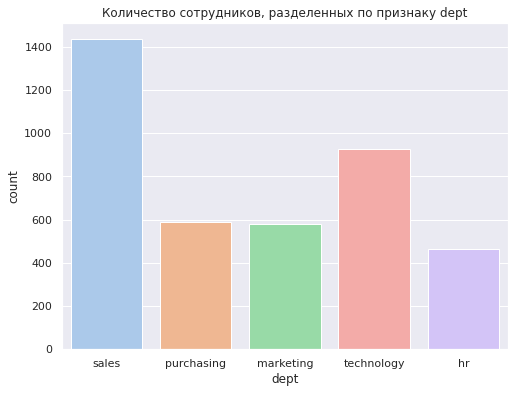

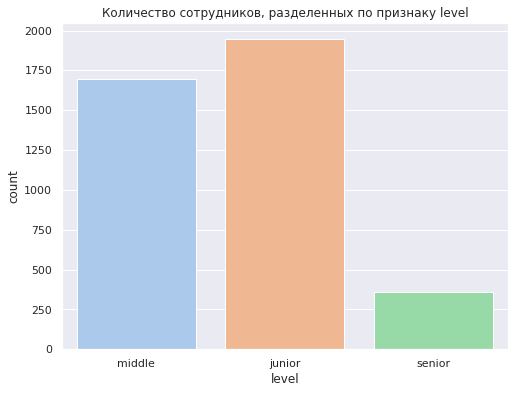

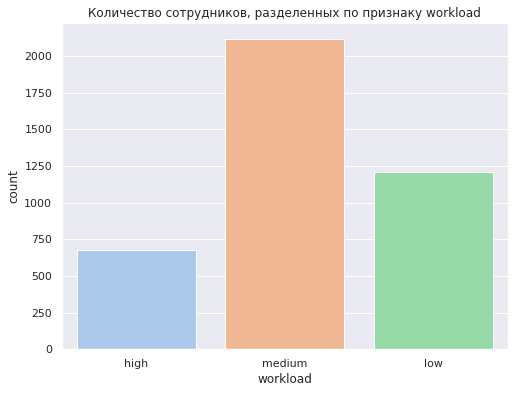

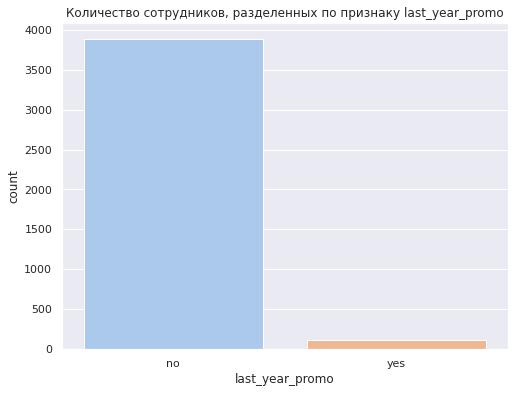

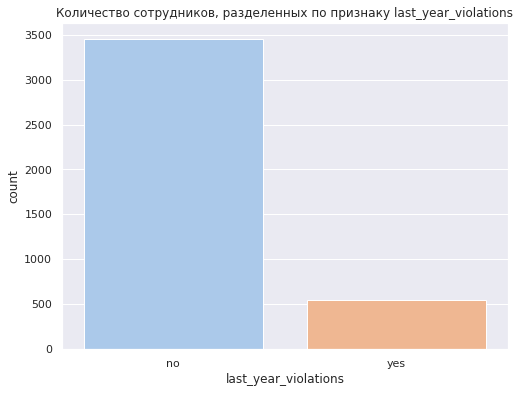

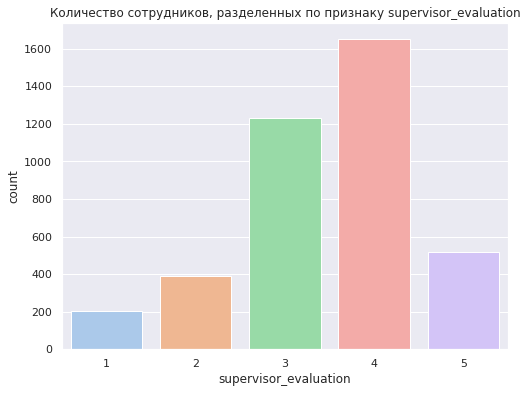

In [73]:
for category in cat_features_quit:
    cat_features_analys(train_quit, category)    

- Наибольшее число сотрудников в новой тренировочной выборке из отдела продаж, второе место занимает it отдел


- Наибольшее число сотрудников - уровня junior


- В данной тренировочной выборке больше всего пользователей со средним уровнем загрузки. 


- Крайне малое число сотрудников получали повышения.


- Мало сотрудников нарушали трудовой договор


- Наиболее часто встречающиеся оценки от руководителя - 3 и 4. 4 превалирует. 

Перехожу к анализу количественных признаков

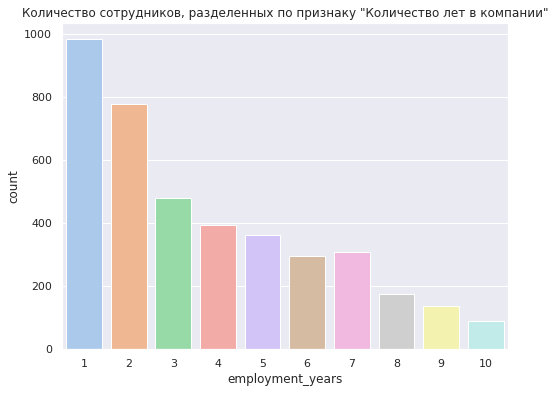

Распределение долей классов - 

 1     0.24625
2     0.19425
3     0.11975
4     0.09825
5     0.09050
7     0.07700
6     0.07400
8     0.04350
9     0.03400
10    0.02250
Name: employment_years, dtype: float64
Доля сотрудников, работающих менее 3 лет = 55.95 %


In [74]:
sns.countplot(
    data = train_quit,
    x = 'employment_years',
    palette = 'pastel',  
    ).set_title('Количество сотрудников, разделенных по признаку "Количество лет в компании"')
    
plt.show()

print('Распределение долей классов - \n\n', train_quit.employment_years.value_counts(normalize=True))

print(
    'Доля сотрудников, работающих менее 3 лет =',
    (((len(train_quit) - len(train_quit.query('employment_years < 3'))) 
    / (len(train_quit)))*100), 
    '%'
    )

Больше половины сотрудников работают в компании менее 3 лет. 

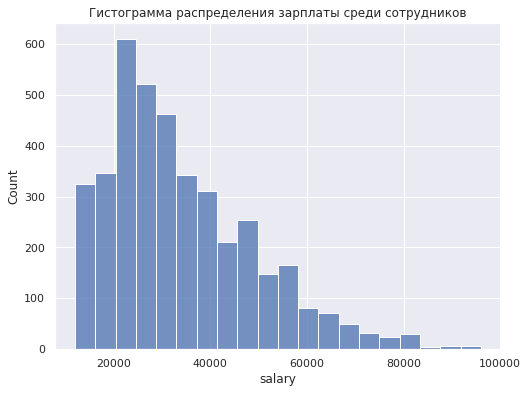

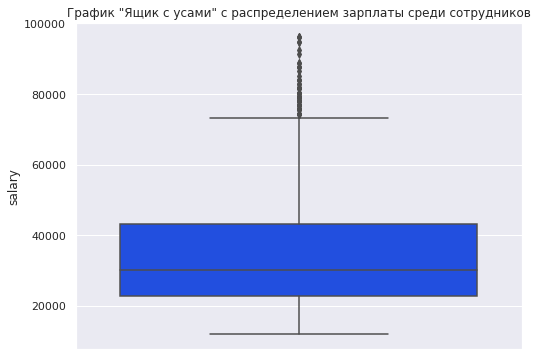

Средняя зарплата в выборке -  33805.8
Медианная зарплата в выборке -  30000.0


In [75]:
sns.histplot(
    data = train_quit['salary'],
    palette = 'bright',
    bins=20
    ).set_title('Гистограмма распределения зарплаты среди сотрудников')
    
plt.show()


sns.boxplot(
    data = train_quit,
    palette = 'bright',
    y = 'salary'
    ).set_title('График "Ящик с усами" с распределением зарплаты среди сотрудников')
    
plt.show()

print('Средняя зарплата в выборке - ', train_quit.salary.mean())
print('Медианная зарплата в выборке - ', train_quit.salary.median())

В тренировочной выборке также используются данные зарплат с выбросами. Среднее значение зарплаты на ~11% больше от медианного, что также косвенно говорит о дисбалансе данных. 

Выводы:

- Наибольшее число сотрудников в новой тренировочной выборке из отдела продаж, второе место занимает it отдел

- В выборке больше всего сотрудников уровня junior

- В данной тренировочной выборке больше всего пользователей со средним уровнем загрузки. 

- Крайне малое число сотрудников получали повышения.

- Мало сотрудников нарушали трудовой договор

- Наиболее часто встречающиеся оценки от руководителя - 3 и 4. 4 превалирует. 

- В датафрейме представлены выбросы по зарплатам - значения признака, скорее всего, принадлежат руководящим должностям или специалистам, чьи компетенции являются уникальными для фирмы.  

Проверяю баланс классов quit == no и quit == yes в тренировочной выборке.

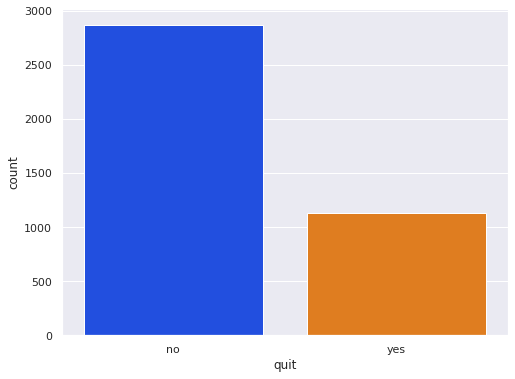

no     0.718
yes    0.282
Name: quit, dtype: float64
Соотношение классов no к yes = 2.55 к 1


In [76]:
sns.countplot(
    data = train_quit,
    x='quit',
    palette = 'bright'
    )

plt.show()

print(train_quit['quit'].value_counts(normalize=True))

print('Соотношение классов no к yes =',
    round(
        (len(train_quit.query('quit == "no"')) / len(train_quit.query('quit == "yes"'))),
        2), 'к 1'
    )

Ввиду присутствия дисбаланса классов, для корректного анализа выборки необходимо провести нормализацию.

Проведу исследовательский анализ данных для построения портрета уволившегося сотрудника

In [77]:
departing_employees = train_quit.query('quit == "yes"')
staying_employees = train_quit.query('quit == "no"')

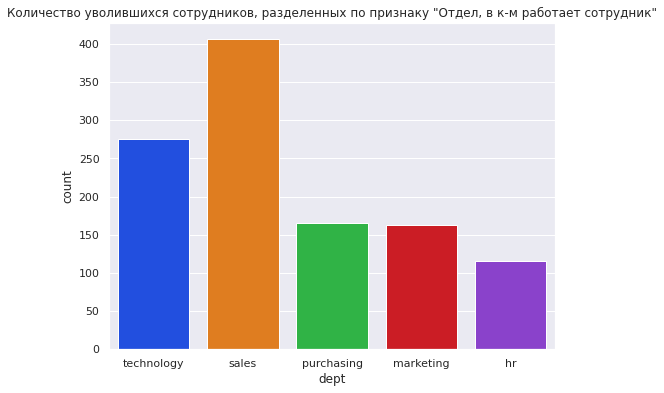

Распределение долей отделов среди уволившихся сотрудников - 

 sales         0.360816
technology    0.244681
purchasing    0.147163
marketing     0.144504
hr            0.102837
Name: dept, dtype: float64


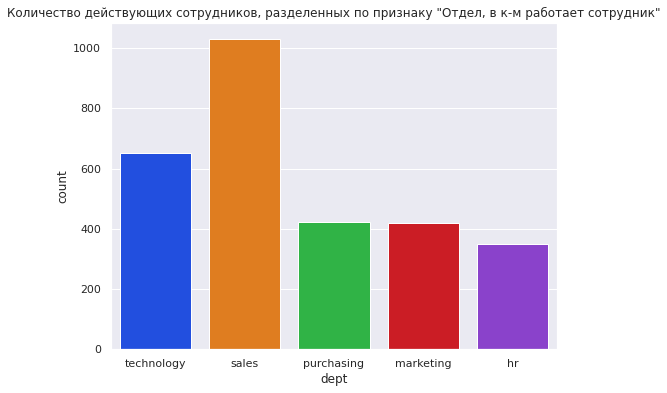

Распределение долей отделов среди действующих сотрудников - 

 sales         0.358983
technology    0.227019
purchasing    0.146936
marketing     0.145891
hr            0.121170
Name: dept, dtype: float64


In [78]:
sns.countplot(
    data = departing_employees.sort_values('dept', ascending = False),
    x = 'dept',
    palette = 'bright',  
    ).set_title('Количество уволившихся сотрудников, разделенных по признаку "Отдел, в к-м работает сотрудник"')
    
plt.show()

print('Распределение долей отделов среди уволившихся сотрудников - \n\n', departing_employees.dept.value_counts(normalize=True))


sns.countplot(
    data = staying_employees.sort_values('dept', ascending = False),
    x = 'dept',
    palette = 'bright',  
    ).set_title('Количество действующих сотрудников, разделенных по признаку "Отдел, в к-м работает сотрудник"')
    
plt.show()

print('Распределение долей отделов среди действующих сотрудников - \n\n', staying_employees.dept.value_counts(normalize=True))


Среди уволившихся сотрудников на 2% больше из it-отдела. Среди действующих на 2% больше из hr отдела.

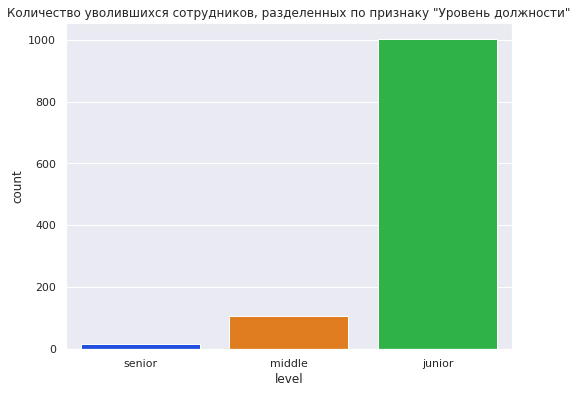

Распределение долей отделов среди уволившихся сотрудников - 

 junior    0.889184
middle    0.095745
senior    0.015071
Name: level, dtype: float64


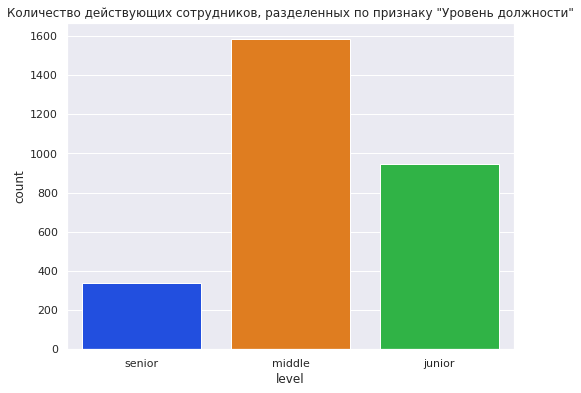

Распределение уровней занимаемой должности действующих сотрудников - 

 middle    0.552228
junior    0.329387
senior    0.118384
Name: level, dtype: float64


In [79]:
sns.countplot(
    data = departing_employees.sort_values('level', ascending = False),
    x = 'level',
    palette = 'bright',  
    ).set_title('Количество уволившихся сотрудников, разделенных по признаку "Уровень должности"')
    
plt.show()

print('Распределение долей отделов среди уволившихся сотрудников - \n\n', departing_employees.level.value_counts(normalize=True))


sns.countplot(
    data = staying_employees.sort_values('level', ascending = False),
    x = 'level',
    palette = 'bright',  
    ).set_title('Количество действующих сотрудников, разделенных по признаку "Уровень должности"')
    
plt.show()

print('Распределение уровней занимаемой должности действующих сотрудников - \n\n', staying_employees.level.value_counts(normalize=True))


Большая часть уволившихся сотрудников имела уровень должности - junior. Среди уволившихся Junior почти 89% в тогда как, например, на senior приходится лишь в ~1,5%, а на middle ~9,5%

Среди действующих сотрудников наибольшая доля middle - более 55% сотрудников.

Можно сделать вывод, что сотрудники junior могут приходить за получением опыта, так как компания охотно набирает такой уровень должности. Впоследствии, после получения 1-2 лет опыта работы сотрудник уходит в другую компанию. 

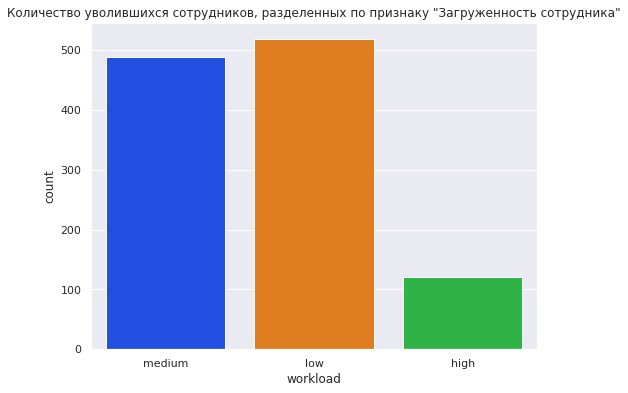

Распределение загруженности среди уволившихся сотрудников - 

 low       0.460106
medium    0.432624
high      0.107270
Name: workload, dtype: float64


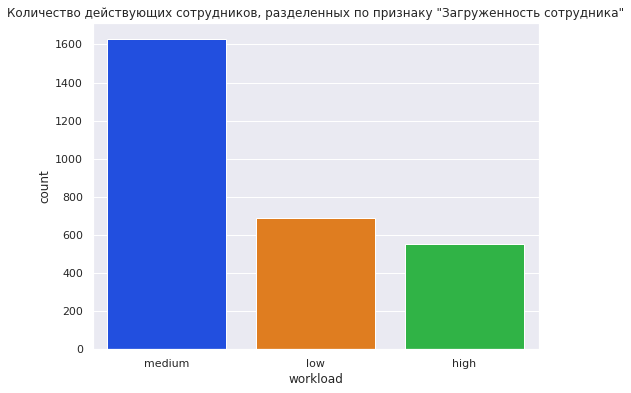

Распределение загруженности действующих сотрудников - 

 medium    0.567549
low       0.239903
high      0.192549
Name: workload, dtype: float64


In [80]:
sns.countplot(
    data = departing_employees.sort_values('workload', ascending = False),
    x = 'workload',
    palette = 'bright',  
    ).set_title('Количество уволившихся сотрудников, разделенных по признаку "Загруженность сотрудника"')
    
plt.show()

print('Распределение загруженности среди уволившихся сотрудников - \n\n', departing_employees.workload.value_counts(normalize=True))


sns.countplot(
    data = staying_employees.sort_values('workload', ascending = False),
    x = 'workload',
    palette = 'bright',  
    ).set_title('Количество действующих сотрудников, разделенных по признаку "Загруженность сотрудника"')
    
plt.show()

print('Распределение загруженности действующих сотрудников - \n\n', staying_employees.workload.value_counts(normalize=True))


Уволившиеся сотрудники имели низкую или среднюю загрузку. Скорее всего, в связи с низким уровнем компетенций. Действущие сотрудники в большей своей части имеют среднюю загрузку (56,7% от общего числа). Этот показатель говорит о том, что в компании неплохо налажены рабочие процессы, но все еще есть куда стремиться, даже несмотря на высокое число junior'ов.

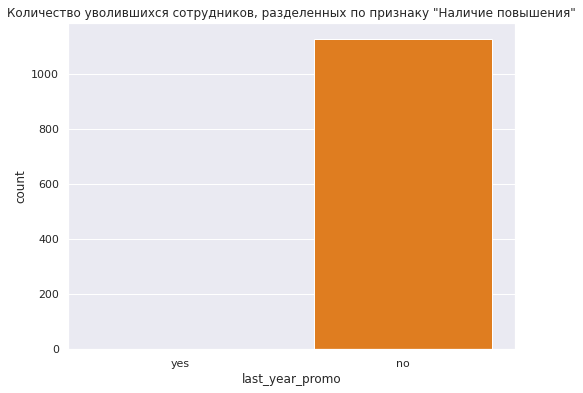

Доли повышения среди уволившихся сотрудников - 

 no     0.999113
yes    0.000887
Name: last_year_promo, dtype: float64


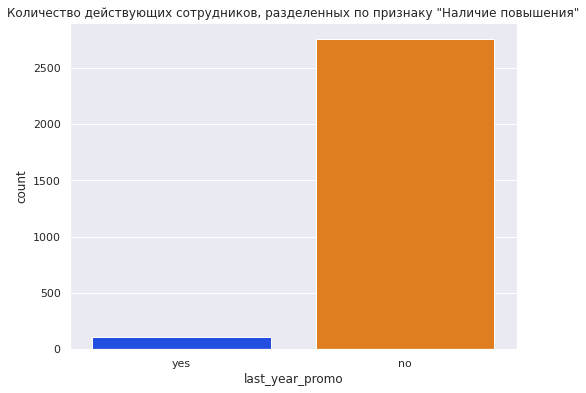

Доли повышения действующих сотрудников - 

 no     0.961003
yes    0.038997
Name: last_year_promo, dtype: float64


In [81]:
sns.countplot(
    data = departing_employees.sort_values('last_year_promo', ascending = False),
    x = 'last_year_promo',
    palette = 'bright',  
    ).set_title('Количество уволившихся сотрудников, разделенных по признаку "Наличие повышения"')
    
plt.show()

print('Доли повышения среди уволившихся сотрудников - \n\n', departing_employees.last_year_promo.value_counts(normalize=True))


sns.countplot(
    data = staying_employees.sort_values('last_year_promo', ascending = False),
    x = 'last_year_promo',
    palette = 'bright',  
    ).set_title('Количество действующих сотрудников, разделенных по признаку "Наличие повышения"')
    
plt.show()

print('Доли повышения действующих сотрудников - \n\n', staying_employees.last_year_promo.value_counts(normalize=True))


Среди уволившихся сотрудников доля получавших повышение за последний год ничтожно мала. В то время как среди действующих сотрудников почти 4% получали повышение за последний год.

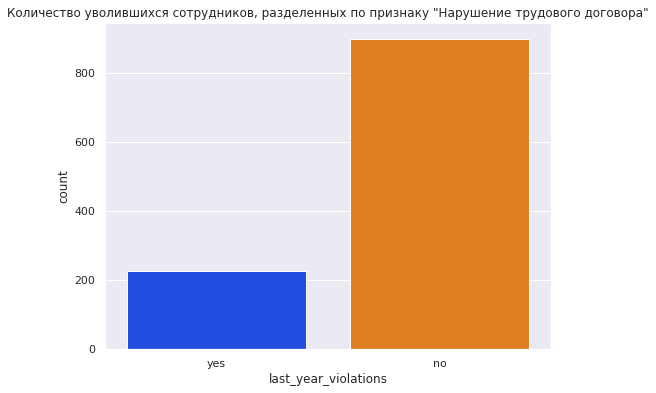

Доли нарушений договора среди уволившихся сотрудников - 

 no     0.797872
yes    0.202128
Name: last_year_violations, dtype: float64


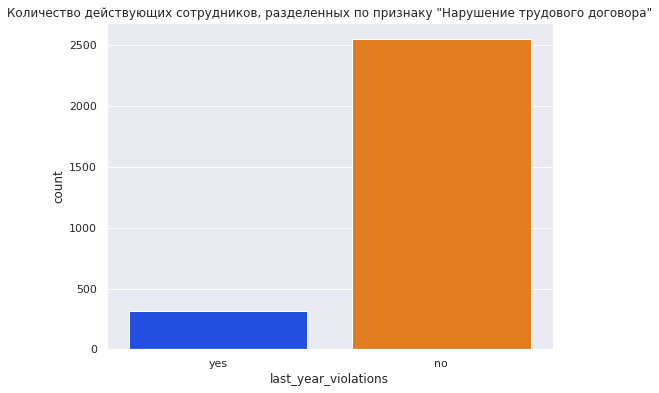

Доли нарушений договора среди действующих сотрудников - 

 no     0.889624
yes    0.110376
Name: last_year_violations, dtype: float64


In [82]:
sns.countplot(
    data = departing_employees.sort_values('last_year_violations', ascending = False),
    x = 'last_year_violations',
    palette = 'bright',  
    ).set_title('Количество уволившихся сотрудников, разделенных по признаку "Нарушение трудового договора"')
    
plt.show()

print('Доли нарушений договора среди уволившихся сотрудников - \n\n', departing_employees.last_year_violations.value_counts(normalize=True))


sns.countplot(
    data = staying_employees.sort_values('last_year_violations', ascending = False),
    x = 'last_year_violations',
    palette = 'bright',  
    ).set_title('Количество действующих сотрудников, разделенных по признаку "Нарушение трудового договора"')
    
plt.show()

print('Доли нарушений договора среди действующих сотрудников - \n\n', staying_employees.last_year_violations.value_counts(normalize=True))


Уволившиеся сотрудники часто нарушали трудовогой договор: приблизительно 20% от общего числа уволившихся. Показатель среди действующих сотрудников существенно ниже - около 11%. 

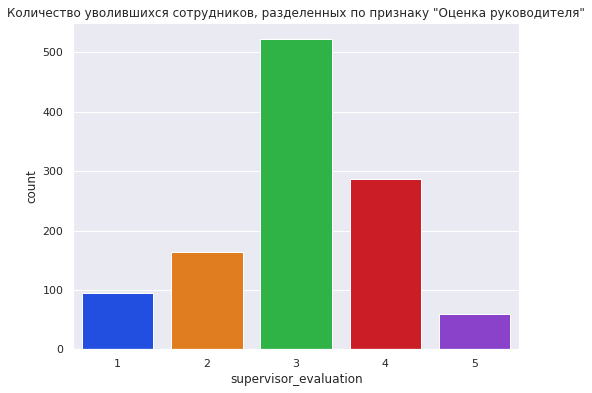

Распределение оценок руководителя среди уволившихся сотрудников - 

 3    0.463652
4    0.253546
2    0.145390
1    0.084220
5    0.053191
Name: supervisor_evaluation, dtype: float64

Средняя оценка среди уволившихся сотрудников -  3.0460992907801416


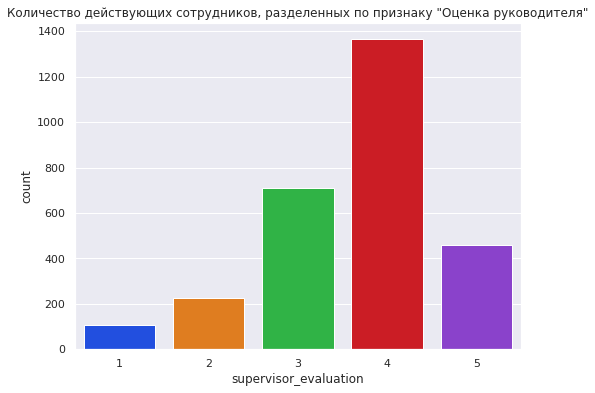

Распределение оценок руководителя среди действующих сотрудников - 

 4    0.476323
3    0.247214
5    0.160167
2    0.079039
1    0.037256
Name: supervisor_evaluation, dtype: float64

Средняя оценка среди действующих сотрудников -  3.643105849582173


In [83]:
sns.countplot(
    data = departing_employees.sort_values('supervisor_evaluation', ascending = False),
    x = 'supervisor_evaluation',
    palette = 'bright',  
    ).set_title('Количество уволившихся сотрудников, разделенных по признаку "Оценка руководителя"')
    
plt.show()

print('Распределение оценок руководителя среди уволившихся сотрудников - \n\n', departing_employees.supervisor_evaluation.value_counts(normalize=True))
print('\nСредняя оценка среди уволившихся сотрудников - ', departing_employees.supervisor_evaluation.mean())


sns.countplot(
    data = staying_employees.sort_values('employment_years', ascending = False),
    x = 'supervisor_evaluation',
    palette = 'bright',  
    ).set_title('Количество действующих сотрудников, разделенных по признаку "Оценка руководителя"')
    
plt.show()

print('Распределение оценок руководителя среди действующих сотрудников - \n\n', staying_employees.supervisor_evaluation.value_counts(normalize=True))
print('\nСредняя оценка среди действующих сотрудников - ', staying_employees.supervisor_evaluation.mean())

Заметна разница в оценках между уволившимися сотрудниками и действующие. Первая категория получала оценку от руководителя в среднем 3 балла, действующие сотрудники получают около 3,6. 

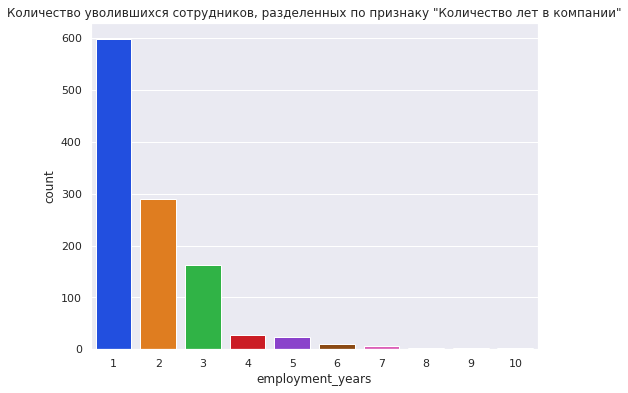

Распределение опыта работы в компании среди уволившихся сотрудников - 

 1     0.531028
2     0.257092
3     0.144504
4     0.023936
5     0.020390
6     0.008865
7     0.006206
8     0.002660
9     0.002660
10    0.002660
Name: employment_years, dtype: float64


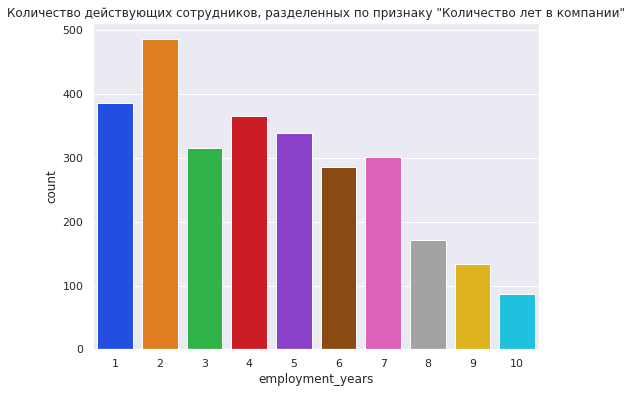

Распределение опыта работы в компании среди действующих сотрудников - 

 2     0.169568
1     0.134401
4     0.127437
5     0.118036
3     0.110028
7     0.104805
6     0.099582
8     0.059540
9     0.046309
10    0.030292
Name: employment_years, dtype: float64


In [84]:
sns.countplot(
    data = departing_employees.sort_values('employment_years', ascending = False),
    x = 'employment_years',
    palette = 'bright',  
    ).set_title('Количество уволившихся сотрудников, разделенных по признаку "Количество лет в компании"')
    
plt.show()

print('Распределение опыта работы в компании среди уволившихся сотрудников - \n\n', departing_employees.employment_years.value_counts(normalize=True))


sns.countplot(
    data = staying_employees.sort_values('employment_years', ascending = False),
    x = 'employment_years',
    palette = 'bright',  
    ).set_title('Количество действующих сотрудников, разделенных по признаку "Количество лет в компании"')
    
plt.show()

print('Распределение опыта работы в компании среди действующих сотрудников - \n\n', staying_employees.employment_years.value_counts(normalize=True))


78% сотрудников среди уволившихся не проработали 3 года. 
Несмотря на существование сотрудников с опытом работы 8 и более лет (окол 12% от штата компании), уволившихся среди них ничтожно мало. 

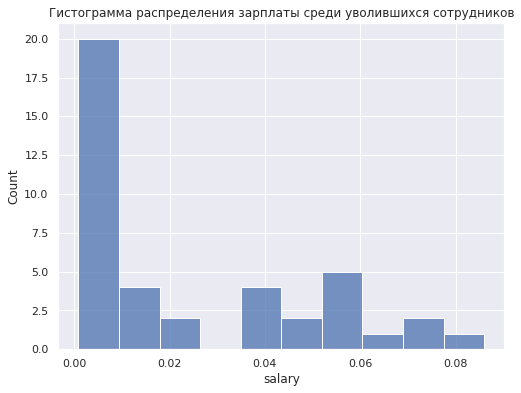

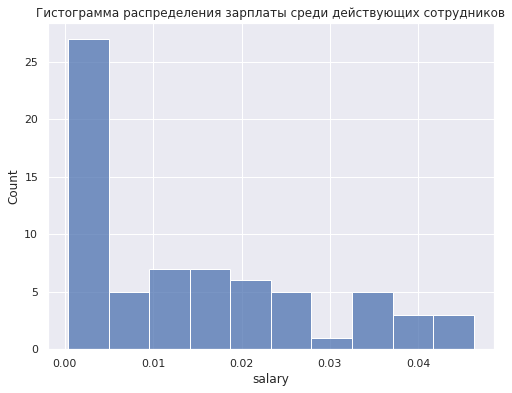

In [85]:
sns.histplot(
    data = departing_employees['salary'].value_counts(normalize=True),
    palette = 'bright',
    bins=10
    ).set_title('Гистограмма распределения зарплаты среди уволившихся сотрудников')
    
plt.show()

sns.histplot(
    data = staying_employees['salary'].value_counts(normalize=True),
    palette = 'bright',
    bins=10
    ).set_title('Гистограмма распределения зарплаты среди действующих сотрудников')
    
plt.show()

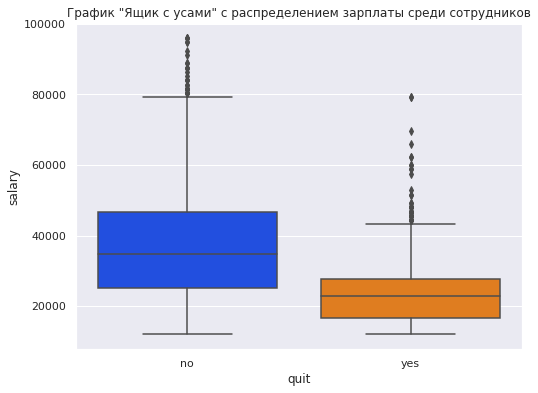

Средняя зарплата уволившихся сотрудников -   23885.106382978724 
Средняя зарплата действующих сотрудников -  37702.22841225627

Медианная зарплата уволившихся сотрудников -  22800.0 
Медианная зарплата действующих сотрудников -  34800.0


In [86]:
sns.boxplot(
    data = train_quit,
    palette = 'bright',
    x = 'quit',
    y = 'salary'
    ).set_title('График "Ящик с усами" с распределением зарплаты среди сотрудников')
    
plt.show()

print('Средняя зарплата уволившихся сотрудников -  ', departing_employees.salary.mean(),
     '\nСредняя зарплата действующих сотрудников - ', staying_employees.salary.mean())

print('\nМедианная зарплата уволившихся сотрудников - ', departing_employees.salary.median(),
     '\nМедианная зарплата действующих сотрудников - ', staying_employees.salary.median())


Средняя зарплата уволившихся сотрудников примерно на 13817,11 ниже, чем у действующих. Медианная зарплата у уволившихся ниже на 12000. 

Портрет уволившегося сотрудника: 

- С большой долей вероятности работал в отделе продаж или в it


- Наибольшее число уволившихся сотрудников имели уровень компетенций junior


- Загрузка низкая или средняя ввиду низкого уровня компетенций


- Не получал повышений за последний год (с учетом того, что большинство уволившихся не работают больше 2 лет, скорее всего, он не получал повышений никогда). 


- Доля сотрудников, получивших выговор за нарушение трудового договора среди уволившихся примерно в 2 раза выше. 


- 78% уволившихся сотрудников работы работали в компании менее 3 лет


- Средняя оценка 3 балла от руководителя


- Средняя зарплата - около 23885.10, медианная - 22800. 

#### Анализ влияния удовлетворенности работой на увольнение 

In [87]:
test_sample_quit = test_features_quit.merge(target_feature_quit, how = 'left', on = 'id')

In [88]:
test_sample_quit = test_sample_quit.merge(target_feature, how = 'left', on = 'id')

In [89]:
test_sample_quit.rename(columns={'job_satisfaction_rate': 'job_satisfaction'}, inplace=True)

In [90]:
watch_df(test_sample_quit)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   dept                   1998 non-null   object 
 2   level                  1999 non-null   object 
 3   workload               2000 non-null   object 
 4   employment_years       2000 non-null   int64  
 5   last_year_promo        2000 non-null   object 
 6   last_year_violations   2000 non-null   object 
 7   supervisor_evaluation  2000 non-null   int64  
 8   salary                 2000 non-null   int64  
 9   quit                   2000 non-null   object 
 10  job_satisfaction       2000 non-null   float64
dtypes: float64(1), int64(4), object(6)
memory usage: 187.5+ KB


id        dept   level workload  employment_years last_year_promo  \
0  485046   marketing  junior   medium                 2              no   
1  686555          hr  junior   medium                 1              no   
2  467458       sales  middle      low                 5              no   
3  418655       sales  middle      low                 6              no   
4  789145          hr  middle   medium                 5              no   
5  429973  purchasing  middle   medium                 6              no   
6  850699  technology  junior   medium                 3              no   
7  500791       sales  middle     high                 9              no   
8  767867   marketing  middle     high                 3              no   
9  937235       sales  junior   medium                 1              no   

  last_year_violations  supervisor_evaluation  salary quit  job_satisfaction  
0                   no                      5   28800   no              0.79  
1                   no                      4   30000   no              0.72  
2                   no                      4   19200   no              0.64  
3                   no                      4   19200   no              0.60  
4                   no                      5   40800   no              0.75  
5                   no                      3   42000  yes              0.67  
6                   no                      3   26400  yes              0.36  
7                   no                      4   49200   no              0.73  
8                  yes                      4   62400   no              0.44  
9                  yes                      3   26400  yes              0.22

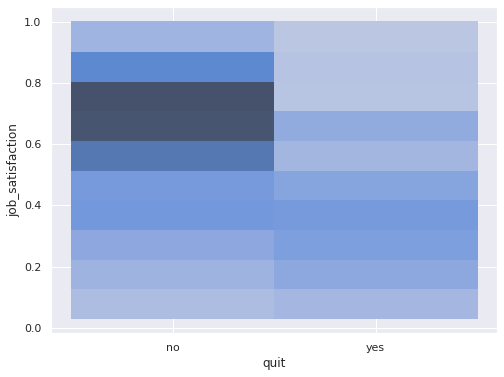

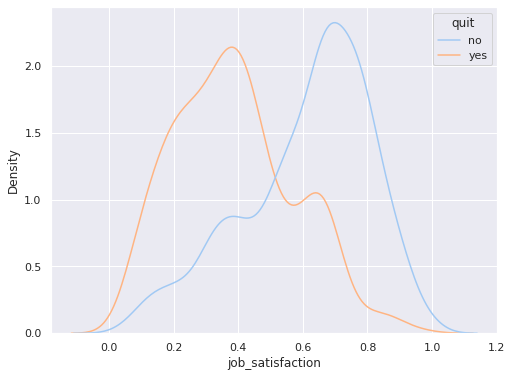

Средний показатель удовлетворенности работой для действующих сотрудников = 0.6120403899721449
Средний показатель удовлетворенности работой для уволившихся сотрудников = 0.38771276595744686
Показатель удовлетворенности работой среди действующих сотрудников в  1.5785923077893158 раз выше


In [91]:
sns.histplot(
    data = test_sample_quit,
    x='quit',
    y='job_satisfaction',
    palette = 'pastel',
    stat='density',
    common_norm=False,
    bins=10
    )
    
plt.show()

sns.kdeplot(
    data = test_sample_quit,
    x='job_satisfaction',
    hue='quit',
    palette = 'pastel',
    common_norm=False
    )
    
plt.show()

stay_sample = test_sample_quit.query('quit == "no"')
left_sample = test_sample_quit.query('quit == "yes"')
print(
    'Средний показатель удовлетворенности работой для действующих сотрудников =',
    (stay_sample.job_satisfaction.mean())
    )

print(
    'Средний показатель удовлетворенности работой для уволившихся сотрудников =',
    (left_sample.job_satisfaction.mean())
    )

print(
    'Показатель удовлетворенности работой среди действующих сотрудников в ',
    (stay_sample.job_satisfaction.mean() / left_sample.job_satisfaction.mean()),
    'раз выше'
     )

Показатель удовлетворенности работой среди сотрудников, которые уволились, заметно ниже. Таким образом, можно сделать вывод, что влияние удовлетворенности работой на решение об увольнении заметное. 

## Добавление нового входного признака

Добавляю в тренировочную выборку предсказания 

In [92]:
train_quit['job_satisfaction'] = rand_search_4.best_estimator_.predict(train_quit.drop(['id','quit'], axis=1))

## Матрица корреляции

In [93]:
interval_features = [     # записываю интервальные признаки в переменную
    'job_satisfaction',
    'salary'
    ]

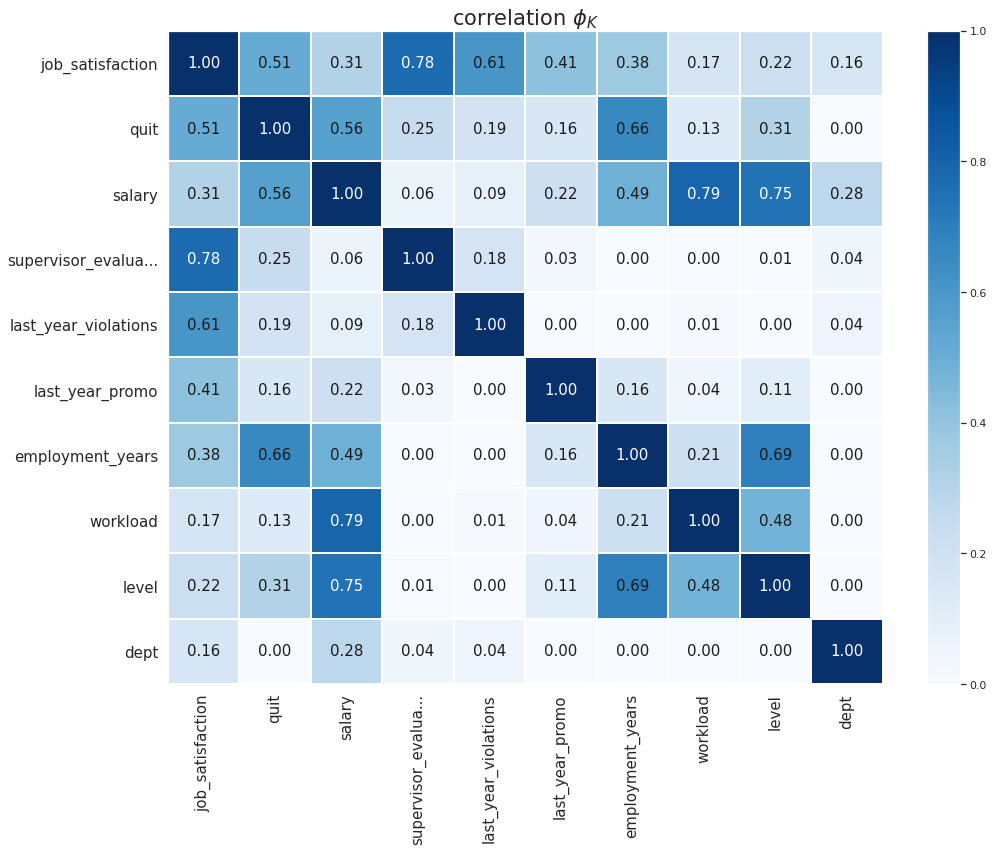

In [94]:
# корреляционный анализ датафрема train_df
phik_overview = train_quit.drop('id',axis=1).phik_matrix(interval_cols=interval_features)

plot_correlation_matrix(
    phik_overview.values, 
    x_labels=phik_overview.columns, 
    y_labels=phik_overview.index, 
    title=r"correlation $\phi_K$", 
    fontsize_factor=1.5,
    vmin=0, vmax=1,
    color_map='Blues',
    figsize=(15, 12)
    )

## Построение новой модели

In [95]:
train_quit_model = train_quit.set_index('id')

In [96]:
train_quit = train_quit.drop_duplicates()

In [97]:
X_train = train_quit_model.drop(['quit'], axis = 1)

X_test = test_sample_quit.drop(['id', 'quit'], axis = 1)

y_train = train_quit_model['quit']

y_test = test_sample_quit['quit']

In [98]:
label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
pred_classes = [1,0]
print(label_encoder.inverse_transform(pred_classes))

['yes' 'no']


In [99]:
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']

ord_columns = ['level', 'workload'] 

num_columns = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction']

In [100]:
ohe_pipe = Pipeline(
        [
            ('simpleImputer_ohe_one',SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
            ('simpleImputer_ohe_two',SimpleImputer(missing_values=' ', strategy='most_frequent')),
            ('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse=False))
        ]
    )

ord_pipe = Pipeline(
    [
        ('simpleImputer_ord_one', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('simpleImputer_ord_two', SimpleImputer(missing_values=' ', strategy='most_frequent')),
        ('ord', OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'senior'],
                    ['low', 'medium', 'high']
                ], 
                handle_unknown='use_encoded_value',
                unknown_value=np.nan
                ))
    ]
)

data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)


pipe_final = Pipeline(
    [
        (
            'preprocessor', data_preprocessor
        ),
        (
            'models', DecisionTreeClassifier(random_state=RANDOM_STATE)
        )
    ]
)

pipe_final.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe_one',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('simpleImputer_ohe_two',
                                                                   SimpleImputer(missing_values=' ',
                                                                                 strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['dept', 'last_year_promo',
 

In [101]:
param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(5,13),
        'models__max_features': range(5,13),
        'models__min_samples_split': range(3,13),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'] 
    },
    
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(3,12),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(3,10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

In [102]:
rand_search_quit = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    n_iter=30,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=RANDOM_STATE
)

rand_search_quit.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe_one',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('simpleImputer_ohe_two',
                                                                                                SimpleImputer(missing_values=' ',
                                                                                                              strategy='most_frequent')),
                                                                                          

In [103]:
print('Лучшая модель и её параметры:\n\n', rand_search_quit.best_estimator_)
print('Метрика лучшей модели при кросс-валидации:', rand_search_quit.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe_one',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('simpleImputer_ohe_two',
                                                                   SimpleImputer(missing_values=' ',
                                                                                 strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                               

In [104]:
y_test_pred = ( 
    rand_search_quit.best_estimator_.predict_proba(
        test_sample_quit.drop(['id', 'quit'], axis = 1)
        )[:,1]
    )

In [105]:
print(
    f'Метрика ROC-AUC на тестовой выборке: \
    {roc_auc_score(test_sample_quit["quit"], y_test_pred)}'
    )

Метрика ROC-AUC на тестовой выборке:     0.9286538898437345


Вывод: Лучшей моделью, подобранной при помощи RandomizedSearch оказалась модель DecisionTreeClassifier с гиперпараметрами: max_depth=6, max_features=12, min_samples_split=12, random_state=48. На тренировочной выборке при кросс-валидации она показала значение метрики ROC-AUC = 0.9276. Метрика ROC-AUC на тестовой выборке составляет 0.9286. 

# Общий вывод

Была проделана работа по построению модели машинного обучения для использования в hr-аналитике. 

По результатам предобработки данных были обнаружены пропуски данных и опечатки. Было принято решение устранить пропуски данных в рамках работы с пайплайном.

Исследовательский анализ данных по представленным датафреймам дал первичное представление о данных:

 Заметна высокая корреляция между высокой удовлетворенностью и повышением. Возможно, в компании стоит разработать программу гарантированного карьерного роста: прописать сложную иерархию с конкретными ступенями для каждого отдела, а также расписать необходимые компетенции для повышения по службе.


- Крайне высокая корреляция между нарушением трудового договора и низкой удовлетворенностью. Так как число нарушений условий очень велико (около 12,5%) нужно проверить условия договоров. Есть вероятность, что жесткий трудовой договор является инструментом депремирования или аналогичного негативного воздействия на сотрудника. 


- Нужно больше данных по теме большого количества новичков (специалистов, которые 1-2 года в компании). Это является либо признаком большого расширения штата, связанного с освоением новых ниш и рынков, либо с текучкой кадров. в рамках этого пункта хотелось бы увидеть статистику по увольнениями персонала.


- Заметна высокая корреляция оценки сотрудника руководителем и удовлетворенность компанией. Однако, как один фактор влияет на другой: если оценка открытая, то она может мотивировать сотрудника к положительной оценке организации; если оценка закрытая то это показывает, что удовлетворенность - отражение производительности труда работника, которая отмечена руководителем. 

После проведения корреляционного анализа было построено несколько моделей оцененных скорингом smape. Лучшей оказалась линейная модель DecisionTreeRegressor max_depth=13, max_features=9, min_samples_leaf=3, random_state=48. На основе модели было сделано предсказание удовлетворенности работой для тренировочного датафрейма во второй части работы.




Вторая часть работы была посвящена предсказанию возможности ухода сотрудника из компании. Для постоения модели были использованы аналогичные шаги: предобработка, исследовательский и корреляционный анализ данных. 

По результатам исследовательского анализа тренировочного датафрейма были сделаны сдедующие выводы: 

- Наибольшее число сотрудников в новой тренировочной выборке из отдела продаж, второе место занимает it отдел

- Больше всего сотрудников уровня junior, 

- Средний уровень загрузки превалирует в выборке.

- Повышение за последний год получала малая доля сотрудников

- Также, мало сотрудников нарушали трудовой договор

- Наиболее часто встречающиеся оценки от руководителя - 3 и 4.

- В датафрейме представлены выбросы по зарплатам - значения признака, скорее всего, принадлежат руководящим должностям или специалистам, чьи компетенции являются уникальными для фирмы.  

После анализа общего датафрейма был проведен анализ с разбивкой по целевому признаку. Анализировались выборки ушедших с работы и оставшихся. На основе анализа был составлен потрет уволившегося сотрудника: 

- С большой долей вероятности работал в отделе продаж или в it


- Наибольшее число уволившихся сотрудников имели уровень компетенций junior


- Загрузка низкая или средняя ввиду низкого уровня компетенций


- Не получал повышений за последний год (с учетом того, что большинство уволившихся не работают больше 2 лет, скорее всего, он не получал повышений никогда). 


- Доля сотрудников, получивших выговор за нарушение трудового договора среди уволившихся примерно в 2 раза выше. 


- 78% уволившихся сотрудников работы работали в компании менее 3 лет


- Средняя оценка 3 балла от руководителя


- Средняя зарплата - около 23885.10, медианная - 22800. 



Далее был проведен анализ влияния удовлетворенности работой на решение об увольнении. Для этого был построен график распределения и проведено сравнение показателя удовлетворнности работой уволившихся и оставшихся сотрудников. Для этой цели была использована тестовая выборка. Итог: показатель удовлетворенности действующих сотрудников оказался в 1,58 раз выше, чем у уволившихся.

На основе тренировочных данных, очищенных от дубликатов, была построена модель предсказания увольнения сотрудника. По результатам сравнения нескольких моделей и подбора гиперпараметров, лучшей моделью, подобранной при помощи RandomizedSearch оказалась модель DecisionTreeClassifier с гиперпараметрами: max_depth=6, max_features=12, min_samples_split=12, random_state=48. На тренировочной выборке при кросс-валидации она показала значение метрики ROC-AUC = 0.9276. Метрика ROC-AUC на тестовой выборке составляет 0.9286. 

Можно вывести несколько рекомендаций по снижению количества уволившихся сотрудников. Основная их направленность заключается в более бережном "входе" в компанию. Вот некоторые из них:


- Закрепление менторов за новичками: уволившиеся сотрудники часто имеют низкий уровень загруженности. Менторство поможет перераспределять им больше задач, тем самым больше вовлекая в рабочий процесс.


- Пересмотреть условия трудового договора. Примерно каждый пятый из уволившихся сталкивался с нарушениями трудового договора. Из данных нет понимания, что это за нарушения. Возможно, это мелкие проступки, такие как незначительные опоздания, запрет обедать на рабочем месте, обязательный дресс-код. Однако, такие замечания уволившиеся получали часто. 


- Для новых сотрудников внедрить свою систему оценки, отличную от общей. Так как новые сотрудники оцениваются наравне с теми, кто работает в компании не первый год, средняя оценка ушедших сотрудников (78% из которых уходят в первые два года) заметно меньше: 3 балла у ушедших и 3,6 у действующих. 


- Рассмотреть возможность внедрения более частой переоценки: из уволившихся сотрудников повышение получали менее 1%. Возможно, переоценка, проводимая 1 раз в полгода для новичков, могла бы положительно повлиять на их решение остаться. 